## Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unyt

import os
from glob import glob
from pathlib import Path

# For Swift Emulator training and validation
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.io.swift import load_parameter_files
from swiftemulator.emulators import gaussian_process, gaussian_process_bins, gaussian_process_mcmc, gaussian_process_one_dim, linear_model, multi_gaussian_process
from swiftemulator.mean_models.polynomial import PolynomialMeanModel
from swiftemulator.sensitivity import basic, cross_check, cross_check_bins
from swiftemulator.mocking import mock_sweep


# For reading in simulation observables as Velociraptor HDF5 files
from velociraptor.observations import load_observation, load_observations


# For saving emulator for later use
import dill

/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load simulated data (galaxy functions, scaling relations, ...)

In [131]:
snap_prefix = 'simba_s50n512'  # eg. 'simba_s12.5n128'

# Main directory where calibration runs have been performed
root_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x'

# Subdirectory that holds actual calibration runs
cali_dir = 'calibrations'

# Name of simulation observable, eg. 'gsmf'
# obs_name = 'gsmf_log_data_0015'
# obs_name = 'gsmf_log_data_min10gal_0015'
# obs_name = 'bhmsm_binned_log_median_0015'
# obs_name = 'bhmsm_binned_log_median_min10gal_0015'
# obs_name = 'bhmsm_kh13_log_fit_0015'
# obs_name = 'bhmsm_log_data_0015'
# obs_name = 'csfh_log_data'  # eg. 'gsmf'
# obs_name = 'csfh_binned_log_median'
# obs_name = 'quenched_fraction_0015'
# obs_name = 'massive_quenched_fraction_0015'
# obs_name = 'quenched_fraction_v2_0015'
obs_name = 'lowMstar11_quenched_fraction_v2_0015'
# obs_name = 'ssfr_hist_bin_0_0015'

In [132]:
sim_paths = [Path(x) for x in glob(os.path.join(root_dir, cali_dir, 'cali_*', snap_prefix+'_'+obs_name+'.hdf5')) 
             if os.path.exists(x)]
cali_dirs = [Path(x) for x in glob(os.path.join(root_dir, cali_dir, 'cali_*')) 
             if os.path.exists(os.path.join(x, snap_prefix+'_'+obs_name+'.hdf5'))]
cali_dirnames = {dirname.stem: dirname for dirname in cali_dirs}
cali_list = [dirname.stem for dirname in cali_dirs]
# print(sim_paths)
# print(cali_list)
print(len(cali_list))

32


In [133]:
sim_dict = {}
thin = 1

for cali, sim_path in zip(cali_list, sim_paths):
    print(cali)
    sim_file = sim_path
#     sim_data = load_observations(sim_file)[0]
    
    try:
        sim_data = load_observations(sim_file)[0]
    except:
        print('Failed')
        continue

    # Load simulation observable data
    
    x_ = sim_data.x.value
    y_ = sim_data.y.value
    y_err_ = sim_data.y_scatter.value

    
    # Sanitize data of -inf, +inf, NaN values
    # Data for different simulations may have different array lengths
    isfinite = np.isfinite(x_)
    isfinite_err = np.resize(isfinite, np.shape(y_err_))
    x_ = x_[isfinite]
    y_ = y_[isfinite]
    y_err_copy = y_err_[isfinite_err]
    if (y_err_copy.ndim != y_err_.ndim):
        y_err_ = y_err_copy.reshape(y_err_.ndim, -1)
    else:
        y_err_ = y_err_copy
    

    isfinite = np.isfinite(y_)
    isfinite_err = np.resize(isfinite, np.shape(y_err_))
    x_ = x_[isfinite]
    y_ = y_[isfinite]
    y_err_copy = y_err_[isfinite_err]
    if (y_err_copy.ndim != y_err_.ndim):
        y_err_ = y_err_copy.reshape(y_err_.ndim, -1)
    else:
        y_err_ = y_err_copy
    
    
    # Get 1D errors
    y_err_arr = np.array(y_err_)
    if (y_err_arr.ndim!=1):
        mean_y_err_ = np.nanmean(y_err_arr, axis=0)
        max_y_err_ = np.nanmax(y_err_arr, axis=0)
    else:
        mean_y_err_ = y_err_arr
        max_y_err_ = y_err_arr
    
    
    sim_dict[cali] = {'x':x_[::thin], 'y':y_[::thin],
                      'y_err':y_err_, 'mean_y_err':mean_y_err_[::thin], 'max_y_err':max_y_err_[::thin], 
                      'sim_data':sim_data}

cali_0018
cali_0002
cali_0030
cali_0000
cali_0004
cali_0019
cali_0007
cali_0015
cali_0003
cali_0012
cali_0022
cali_0009
cali_0029
cali_0026
cali_0016
cali_0011
cali_0017
cali_0008
cali_0023
cali_0010
cali_0021
cali_0031
cali_0025
cali_0024
cali_0013
cali_0005
cali_0027
cali_0028
cali_0001
cali_0020
cali_0006
cali_0014


In [134]:
sim_data = load_observations(sim_file)[0]
sim_info = {
    'X_LABEL':sim_data.x_description,
    'Y_LABEL':sim_data.y_description,
    'name':sim_data.name,
    'x_units':sim_data.x_units,
    'y_units':sim_data.y_units,
    'comment':sim_data.comment,
    'z':sim_data.redshift,
    'z_lo':sim_data.redshift_lower,
    'z_hi':sim_data.redshift_upper,
    'plot_as':sim_data.plot_as,
}

x:  [15.5]
y:  [0.21428571]
yerr:  [0.09640022]


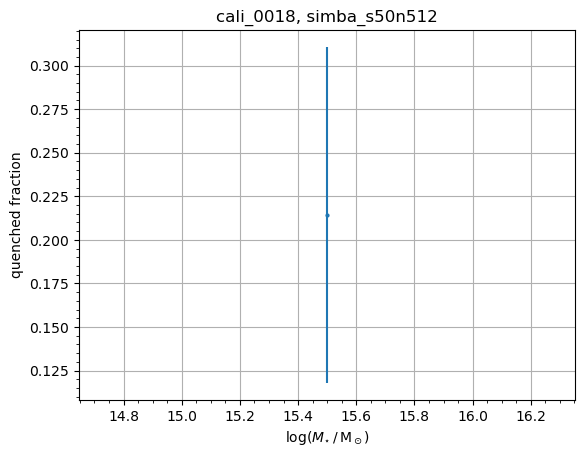

x:  [15.5]
y:  [0.2]
yerr:  [0.21908902]


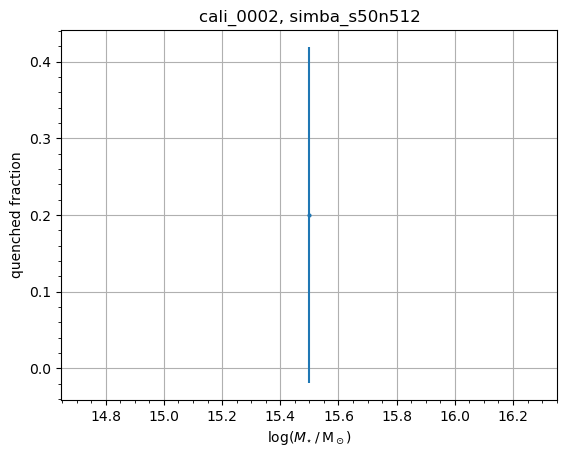

x:  [15.5]
y:  [0.42857143]
yerr:  [0.29574238]


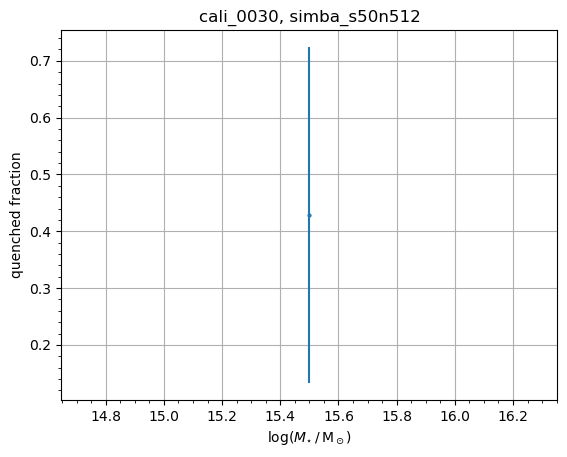

x:  [15.5]
y:  [0.5]
yerr:  [0.27386128]


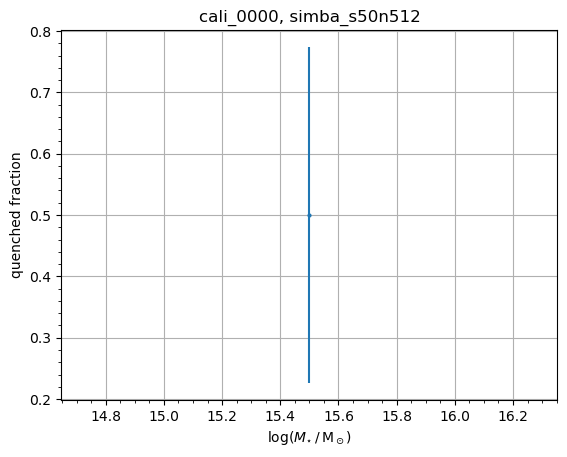

x:  [15.5]
y:  [0.28571429]
yerr:  [0.22908106]


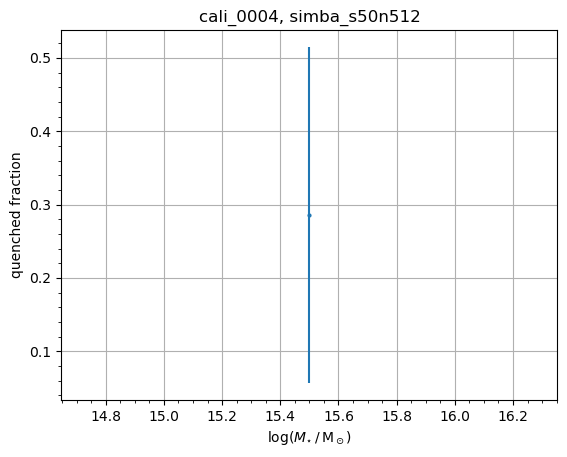

x:  [15.5]
y:  [0.1875]
yerr:  [0.11796616]


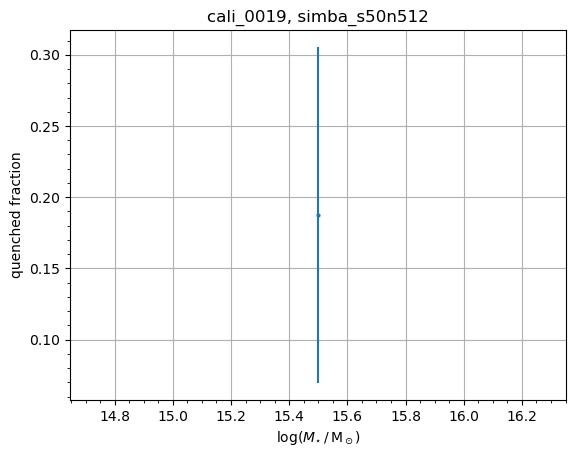

x:  [15.5]
y:  [0.08]
yerr:  [0.01697056]


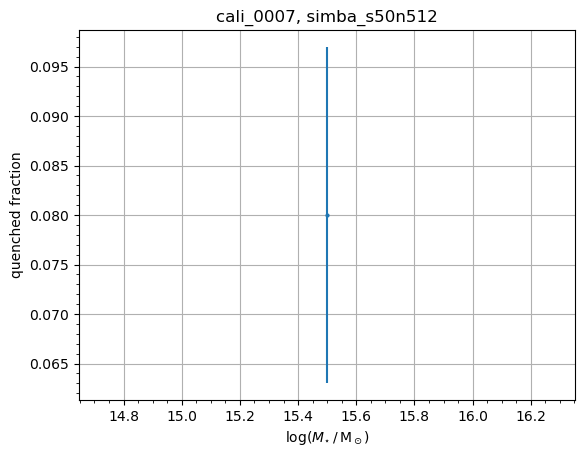

x:  [15.5]
y:  [0.22222222]
yerr:  [0.08685955]


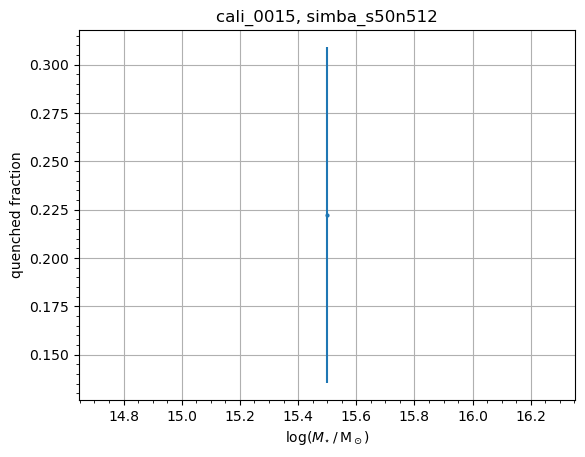

x:  [15.5]
y:  [0.57142857]
yerr:  [0.25325865]


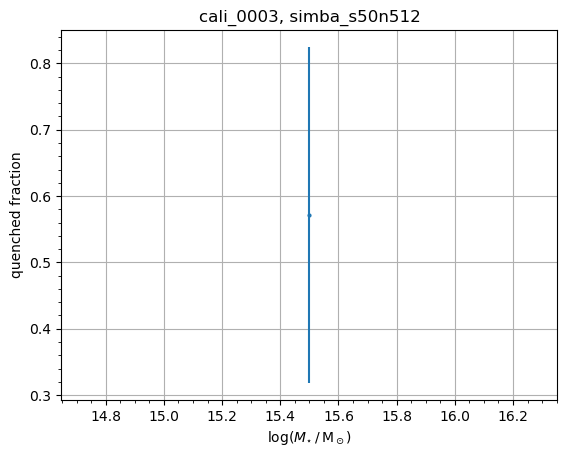

x:  [15.5]
y:  [0.09090909]
yerr:  [0.09495145]


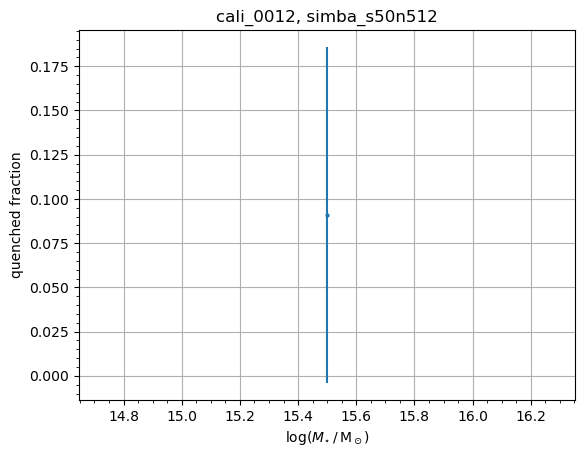

x:  [15.5]
y:  [0.42857143]
yerr:  [0.29574238]


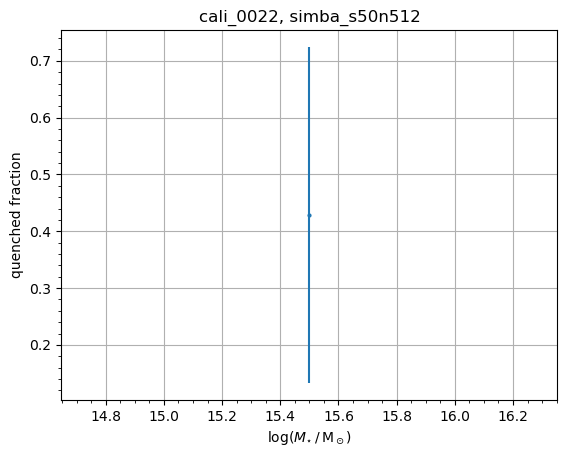

x:  [15.5]
y:  [0.25]
yerr:  [0.16137431]


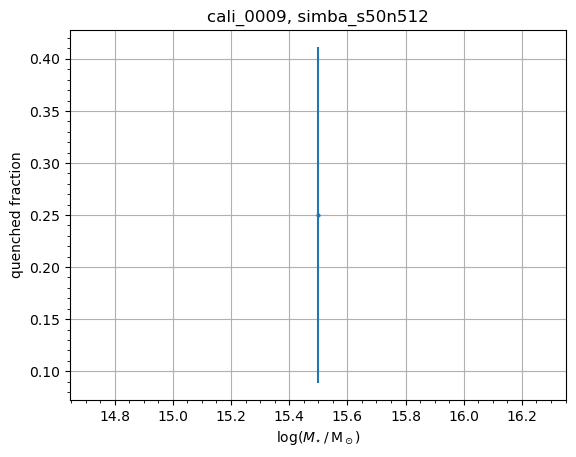

x:  [15.5]
y:  [0.33333333]
yerr:  [0.27216553]


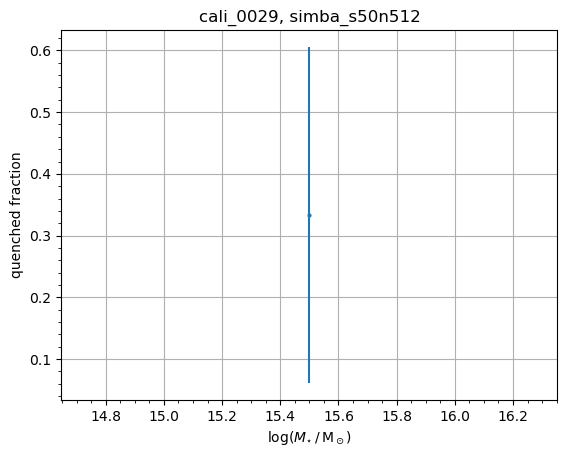

x:  [15.5]
y:  [0.11428571]
yerr:  [0.03015992]


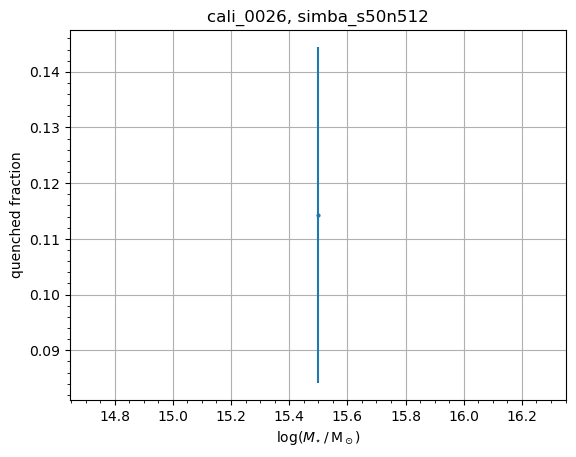

x:  [15.5]
y:  [0.30769231]
yerr:  [0.17592981]


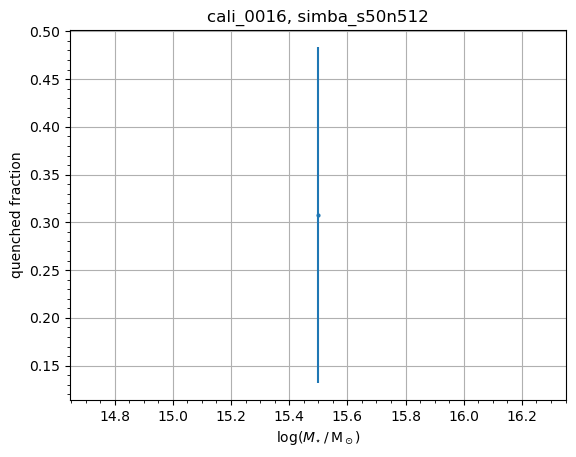

x:  [15.5]
y:  [0.4]
yerr:  [0.33466401]


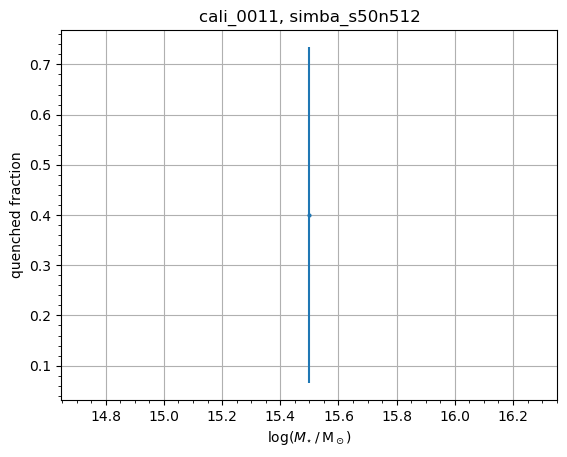

x:  [15.5]
y:  [0.1627907]
yerr:  [0.06634854]


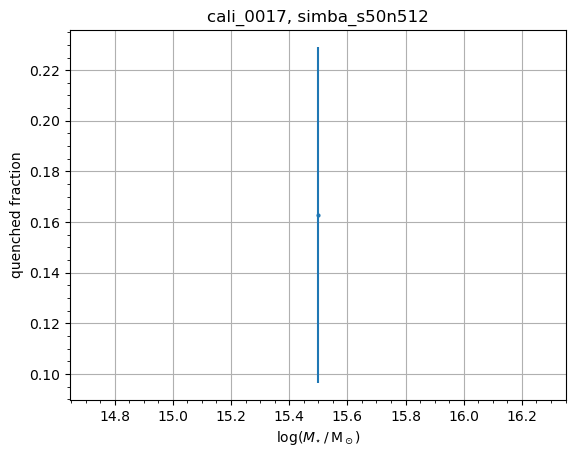

x:  [15.5]
y:  [0.11965812]
yerr:  [0.02392797]


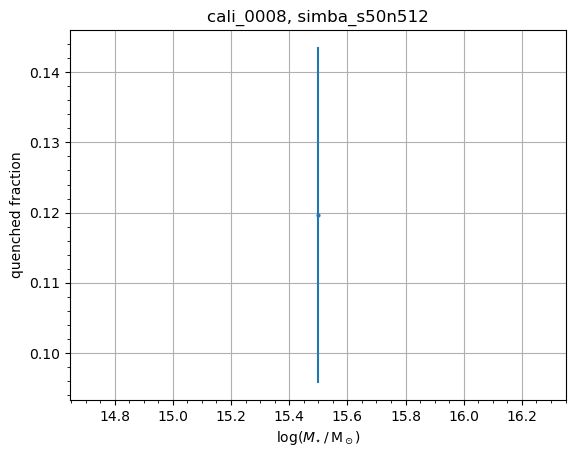

x:  [15.5]
y:  [0]
yerr:  [0.]


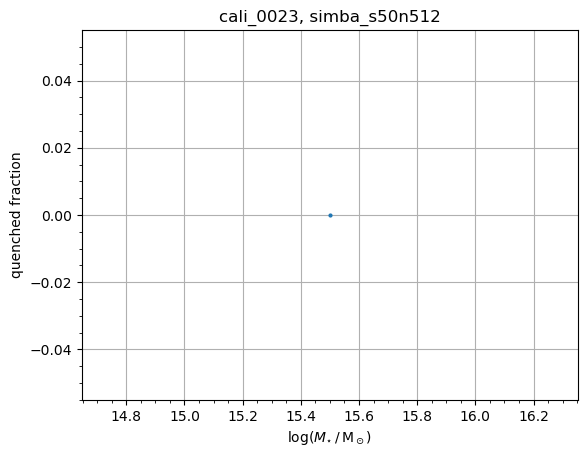

x:  [15.5]
y:  [0.5]
yerr:  [0.4330127]


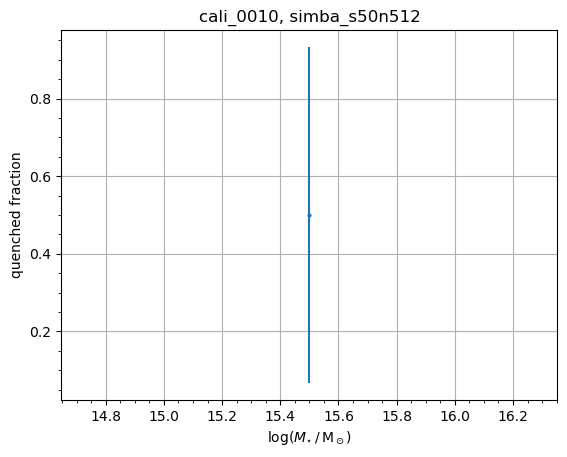

x:  [15.5]
y:  [0.27777778]
yerr:  [0.14042362]


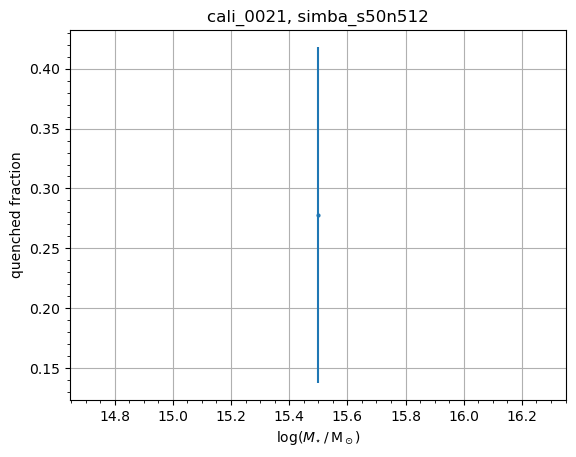

x:  [15.5]
y:  [0.33333333]
yerr:  [0.19245009]


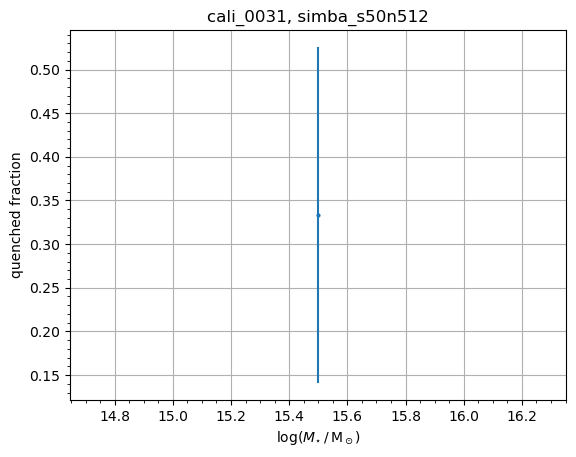

x:  [15.5]
y:  [0.275]
yerr:  [0.09362492]


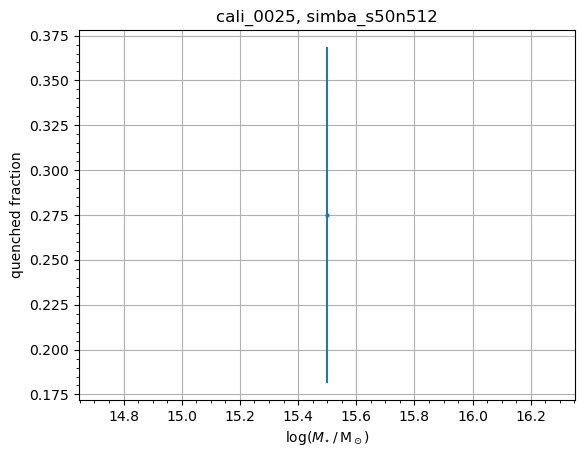

x:  [15.5]
y:  [0.3030303]
yerr:  [0.1093864]


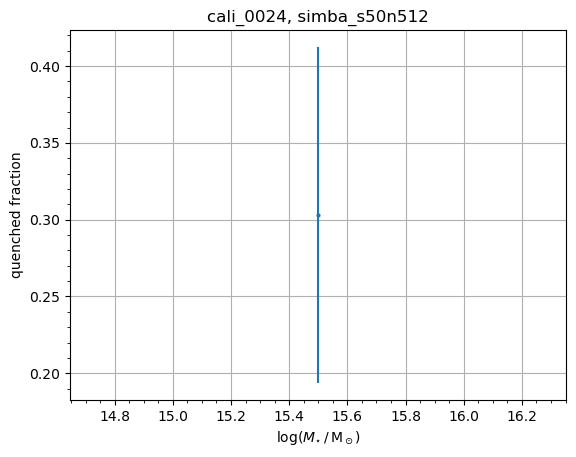

x:  [15.5]
y:  [0.27777778]
yerr:  [0.14042362]


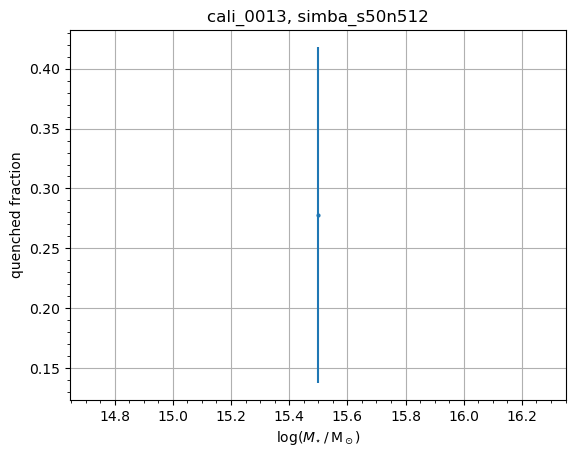

x:  [15.5]
y:  [0.33333333]
yerr:  [0.19245009]


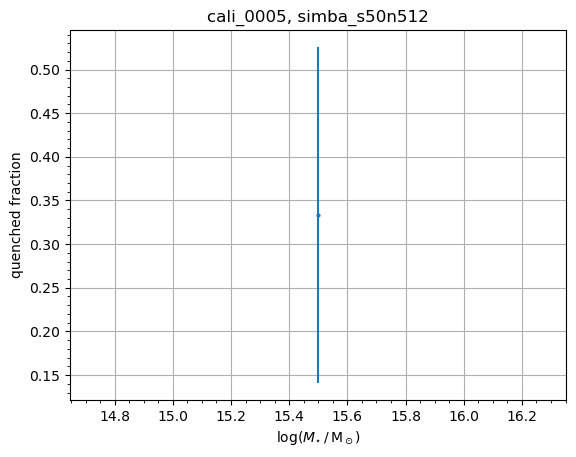

x:  [15.5]
y:  [0.5]
yerr:  [0.4330127]


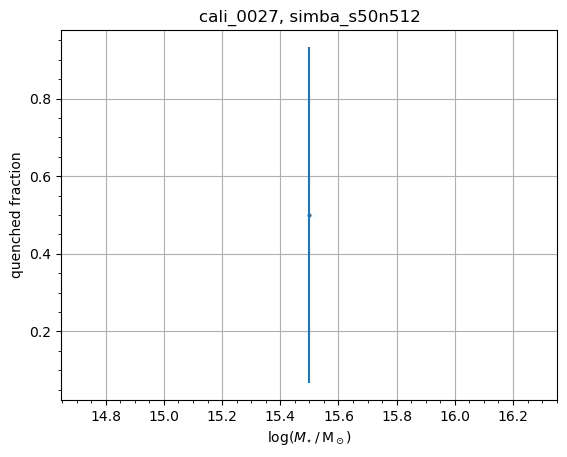

x:  [15.5]
y:  [0.35294118]
yerr:  [0.16759697]


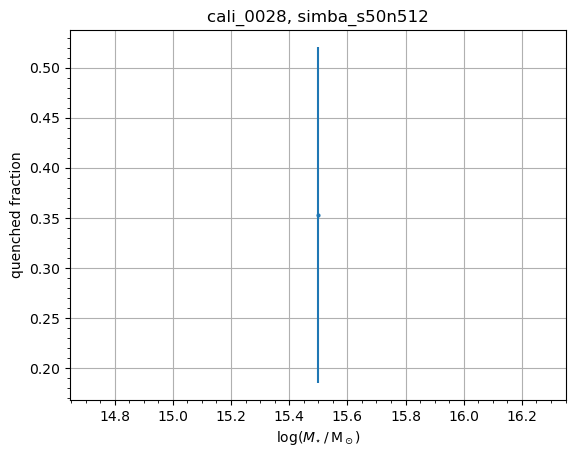

x:  [15.5]
y:  [0.23076923]
yerr:  [0.1478106]


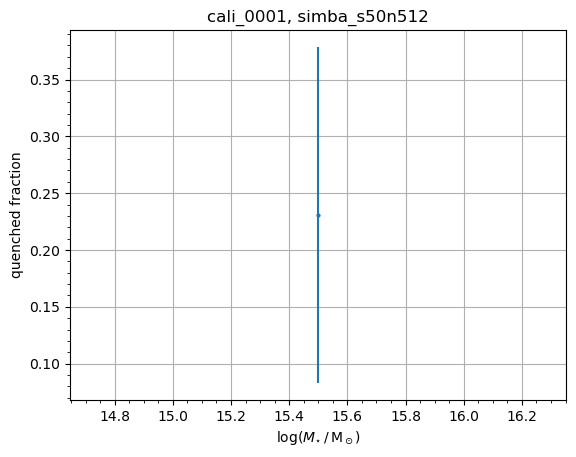

x:  [15.5]
y:  [0.5]
yerr:  [0.61237244]


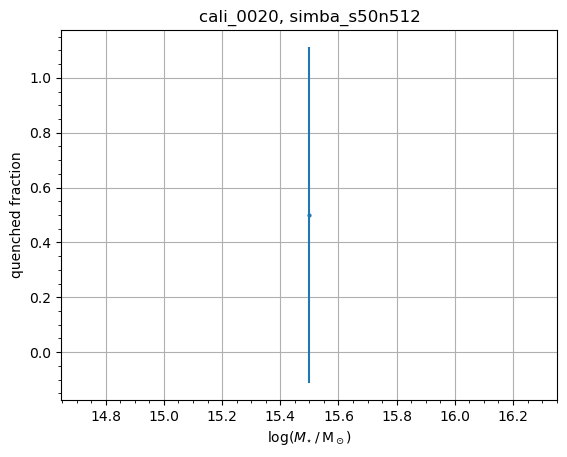

x:  [15.5]
y:  [0.23076923]
yerr:  [0.1478106]


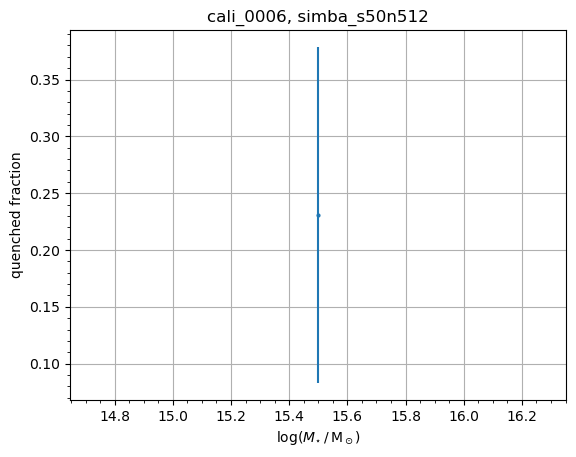

x:  [15.5]
y:  [0.13592233]
yerr:  [0.03871695]


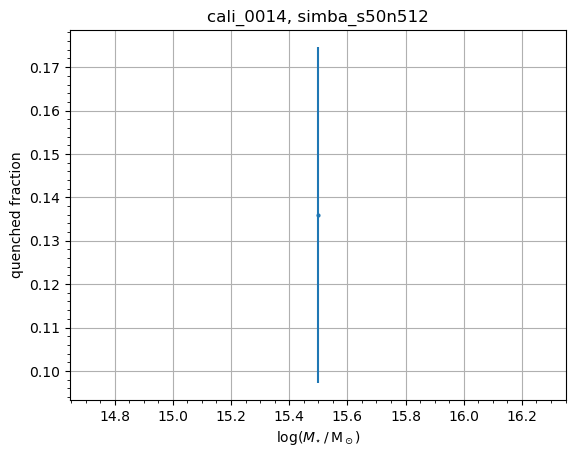

In [93]:
# Plot the observable to check it worked

thin_ = 1
# thin_ = 10 # for CSFH

for cali in sim_dict:
    print("x: ", sim_dict[cali]['x'])
    print("y: ", sim_dict[cali]['y'])
    print("yerr: ", sim_dict[cali]['max_y_err'])    
    
    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s' % (cali, snap_prefix))
    plt.grid()
    plt.minorticks_on()
    plt.errorbar(sim_dict[cali]['x'][::thin_], sim_dict[cali]['y'][::thin_], yerr=sim_dict[cali]['max_y_err'][::thin_], 
                 fmt='o-', markersize=2)
#     plt.scatter(sim_dict[cali]['x'][::thin_], sim_dict[cali]['y'][::thin_], s=2)
    plt.show()

## Specify the model parameters and values

In [135]:
parameter_files = [Path(os.path.join(cali_dir, cali+'.yml')) for cali_dir, cali in zip(cali_dirs, cali_list)]
parameter_filenames = {filename.stem: filename for filename in parameter_files}

In [136]:
model_specification, model_parameters = load_parameter_files(
    filenames=parameter_filenames,
    parameters=[
        "SIMBAFeedback:FIRE_velocity_normalization",
        "SIMBAFeedback:FIRE_eta_normalization",
        "SIMBAAGN:torque_accretion_norm",
        "SIMBAAGN:jet_mass_min_Msun",
    ],
    log_parameters=[
        "SIMBAAGN:jet_mass_min_Msun",
    ],
    parameter_printable_names=[
        "$v_{a}$",
        "$\\eta_{0}$",
        "$\\varepsilon_{\\rm torque}$",
        "$\\log_{10}$ $M_{\\rm BH, lim}/M_{\\rm \odot}$"
    ],
)

In [137]:
modelvalues = {}

# GSMF
# min_x_for_emulator = 6
# min_x_for_emulator = 8.5  # Seems to be resolution limit
# min_x_for_emulator = 9
# min_x_for_emulator = 10
# max_x_for_emulator = 11
# max_x_for_emulator = 11.2
# max_x_for_emulator = 11.6
# max_x_for_emulator = 15

# Mbh-M*
# min_x_for_emulator = 6
# min_x_for_emulator = 8.2
# min_x_for_emulator = 8.5
# min_x_for_emulator = 8.75
# min_x_for_emulator = 9
# min_x_for_emulator = 9.5
# min_x_for_emulator = 10
# max_x_for_emulator = 11
# max_x_for_emulator = 11.2
# max_x_for_emulator = 11.7
# max_x_for_emulator = 12
# max_x_for_emulator = 15

# Quenched Fraction
min_x_for_emulator = 0
max_x_for_emulator = 100

# sSFR Histogram
# min_x_for_emulator = -2.7
# max_x_for_emulator = 0
# max_x_for_emulator = 0.5

# CSFH
# min_x_for_emulator = -1
# max_x_for_emulator = 5

# If too many data points, will take very long to train emulator and use emulator to predict values
thin_ = 1
# thin_ = 10 # for CSHF

# rel_err = 0.02 # for Mbh-M*
rel_err = 0.05 # for CSFH

for cali in model_parameters.model_parameters:
    independent = sim_dict[cali]['x'][::thin_]
    dependent = sim_dict[cali]['y'][::thin_]
    
    # Must choose whether to specify own errorbars
    # or use maximum or mean errorbars (as swift emulator can only handle single value for errorbars)
#     dependent_error = np.abs(rel_err * dependent)
    dependent_error = sim_dict[cali]['max_y_err'][::thin_]
#    dependent_error = [0]*len(dependent)

    range_condition = np.logical_and(independent>=min_x_for_emulator, independent<=max_x_for_emulator)
    
    modelvalues[cali] = {"independent": independent[range_condition],
                         "dependent": dependent[range_condition],
                         "dependent_error": dependent_error[range_condition]}

model_values = se.ModelValues(model_values=modelvalues)

In [138]:
## To check if there are any x bin values appearing only once
## This can make errors pop up when training the emulator, doing the parameter sensitivity analysis
## and performing the cross-check validation

comb_ = np.array([])
for key, val in model_values.model_values.items():
#     print(np.all(np.isfinite(val['independent'])))
#     print(np.all(np.isfinite(val['dependent'])))
#     print(np.all(np.isfinite(val['dependent_error'])))
#     print(max(val['independent']))
    comb_ = np.concatenate((comb_, val['independent']))
#     comb_ = np.append(comb_, val['independent'])
#     comb_ = np.append(comb_, max(val['independent']))
    
# Find unique values and their counts
unique_values, counts = np.unique(comb_, return_counts=True)
print("Unique x values:", unique_values)
print("Number of times:", counts)

# Find values that appear only once
values_appearing_once = unique_values[counts == 1]

# Print the values that appear only once
print("x values appearing only once:", values_appearing_once)

Unique x values: [15.5]
Number of times: [32]
x values appearing only once: []


## Model Parameter Features

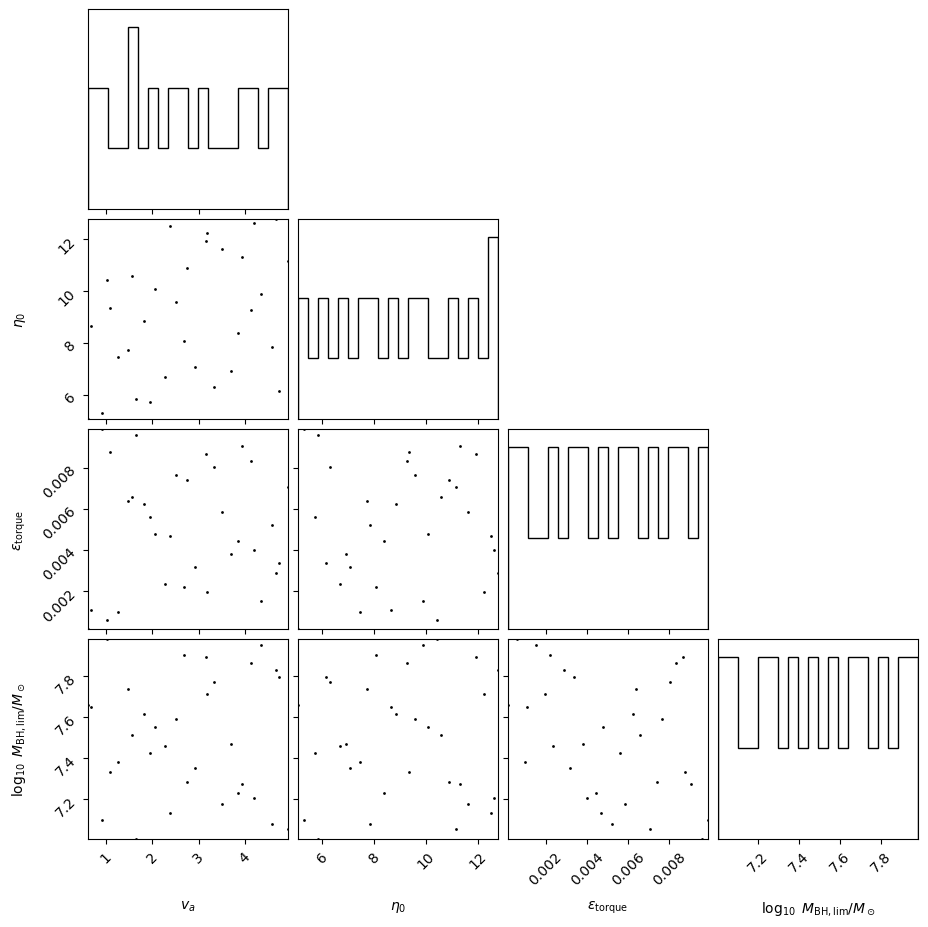

In [98]:
model_parameters.plot_model(model_specification)

## Train emulator

In [139]:
emulator = gaussian_process.GaussianProcessEmulator()  # Default
# emulator = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(mcmc_steps=1000, burn_in_steps=1, walkers=40, use_hyperparameter_error=False)  # With MCMC
# emulator = gaussian_process_bins.GaussianProcessEmulatorBins()  # Gaussian Process Emulator using an emulator for each bins
# emulator = gaussian_process_one_dim.GaussianProcessEmulator1D()  # Gaussian Process Emulator for emulating single values
# emulator = linear_model.LinearModelEmulator(lasso_model_alpha=0)  # Linear Model Emulator
# emulator = multi_gaussian_process.MultipleGaussianProcessEmulator()  # A gaussian process emulator that uses _multiple_ internal emulators to better predict functions that contain a ‘break’.
# polynomial_model = PolynomialMeanModel(degree=4)  # Polynomial mean model
# emulator = gaussian_process.GaussianProcessEmulator(mean_model=polynomial_model)  # Mean model

emulator.fit_model(model_specification=model_specification,
                            model_parameters=model_parameters,
                            model_values=model_values)
emulator.model_specification.sim_info = sim_info

## Make predictions and compare

x:  [15.5]
y:  [0.18800284]
yerr:  [0.00217833]
Slope:  []


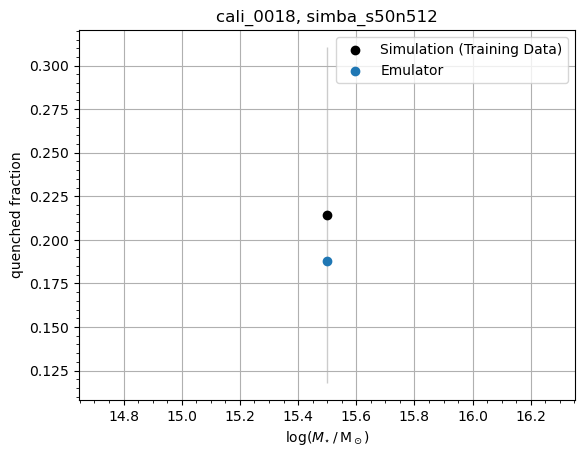

x:  [15.5]
y:  [0.06823972]
yerr:  [0.00268606]
Slope:  []


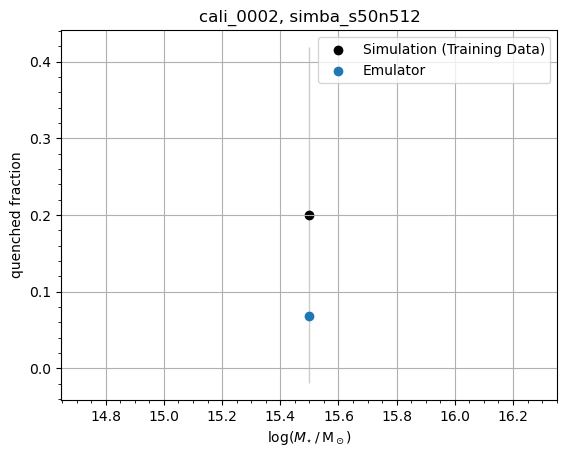

x:  [15.5]
y:  [0.4937885]
yerr:  [0.00275564]
Slope:  []


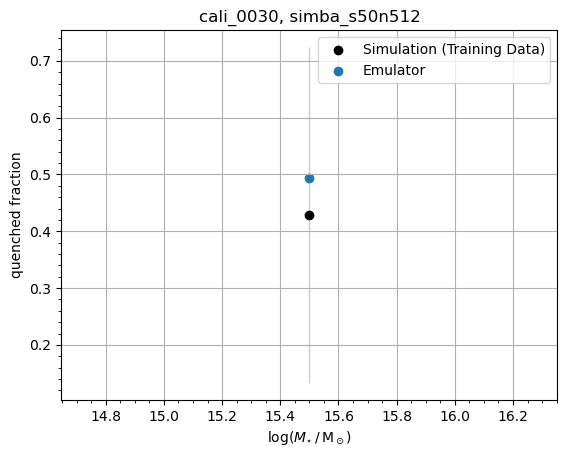

x:  [15.5]
y:  [0.33700053]
yerr:  [0.00274128]
Slope:  []


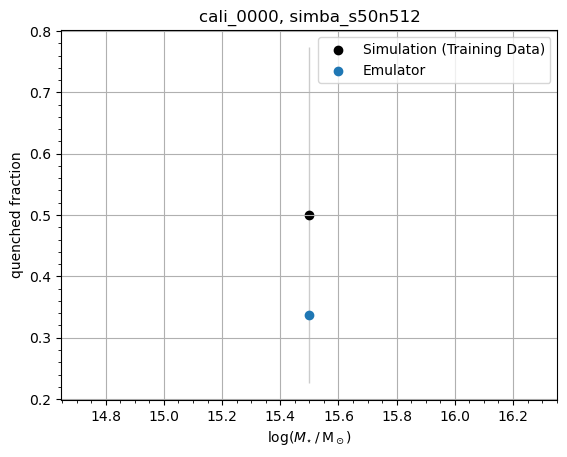

x:  [15.5]
y:  [0.37886604]
yerr:  [0.00269895]
Slope:  []


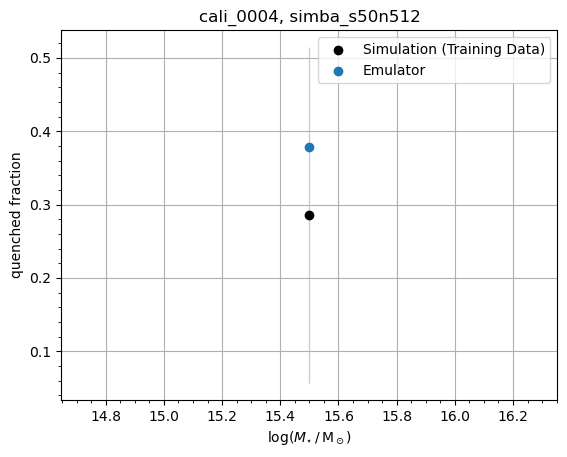

x:  [15.5]
y:  [0.14434853]
yerr:  [0.00236229]
Slope:  []


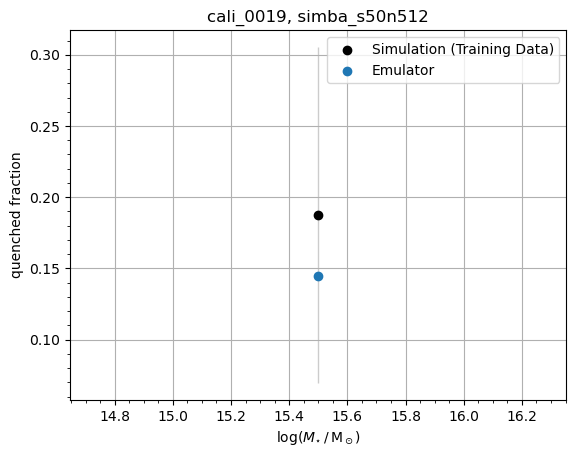

x:  [15.5]
y:  [0.08242778]
yerr:  [0.00026153]
Slope:  []


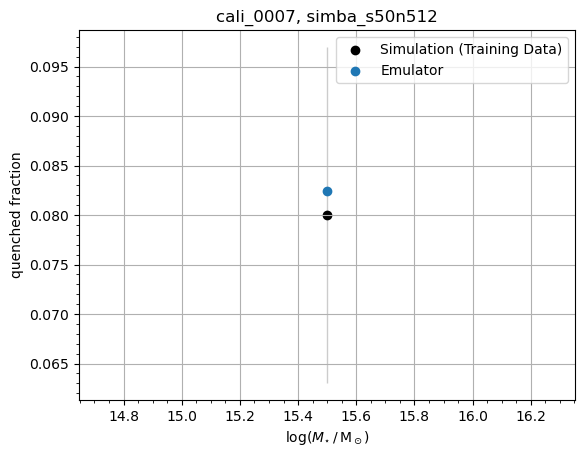

x:  [15.5]
y:  [0.21572124]
yerr:  [0.0020661]
Slope:  []


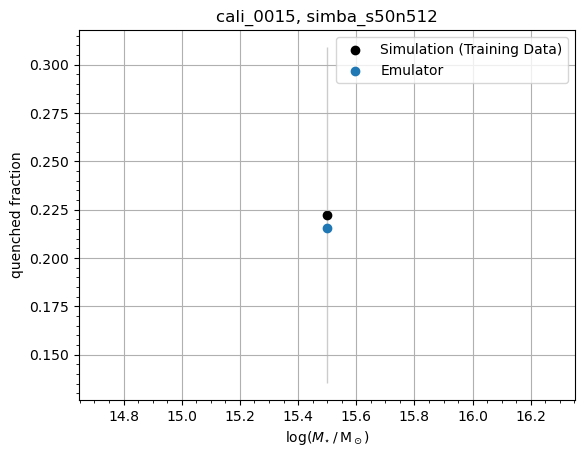

x:  [15.5]
y:  [0.48450199]
yerr:  [0.00272442]
Slope:  []


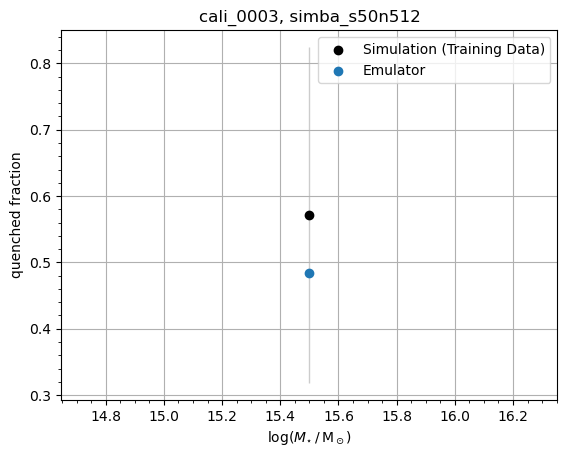

x:  [15.5]
y:  [0.09985303]
yerr:  [0.00216274]
Slope:  []


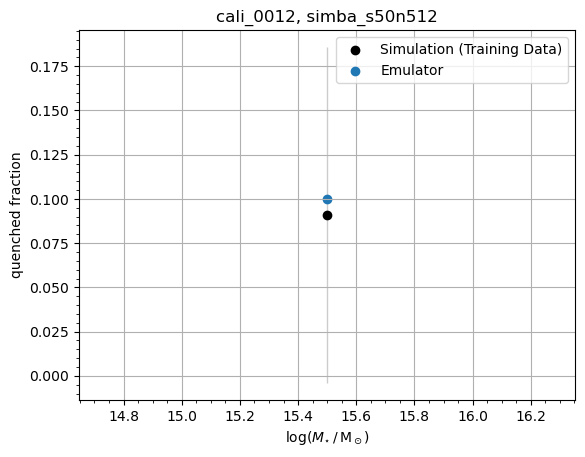

x:  [15.5]
y:  [0.39619367]
yerr:  [0.00275564]
Slope:  []


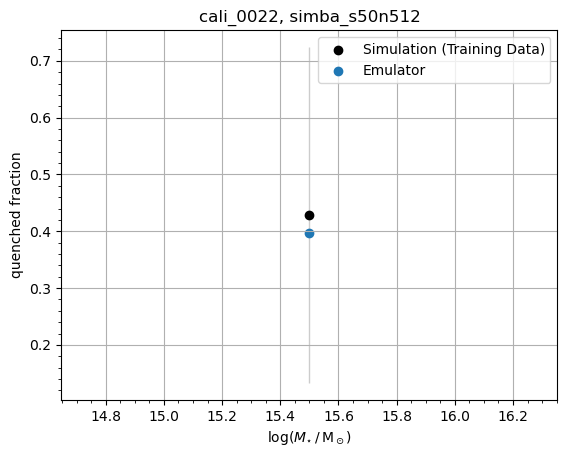

x:  [15.5]
y:  [0.29347398]
yerr:  [0.00256503]
Slope:  []


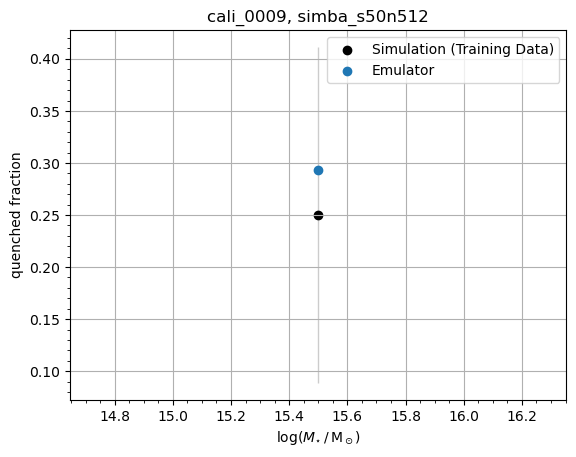

x:  [15.5]
y:  [0.49412784]
yerr:  [0.00274003]
Slope:  []


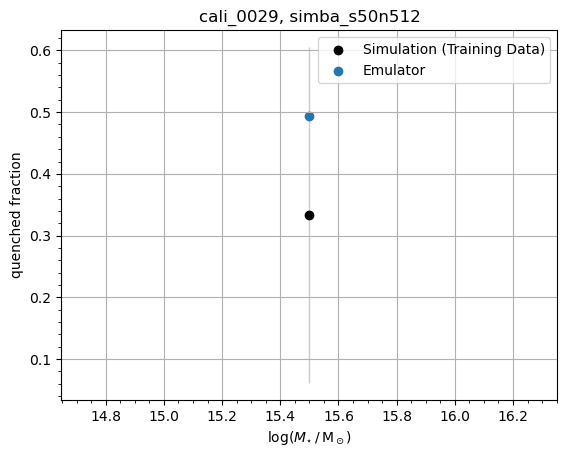

x:  [15.5]
y:  [0.14658131]
yerr:  [0.00068927]
Slope:  []


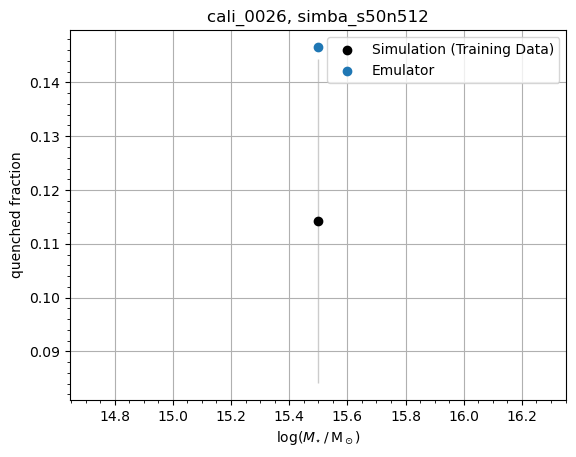

x:  [15.5]
y:  [0.31879875]
yerr:  [0.00260574]
Slope:  []


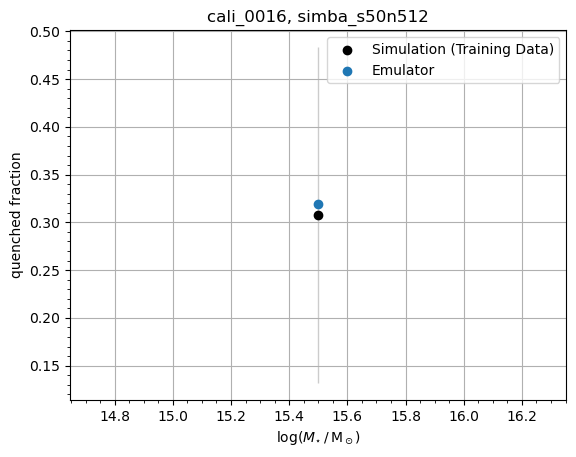

x:  [15.5]
y:  [0.37680826]
yerr:  [0.00277479]
Slope:  []


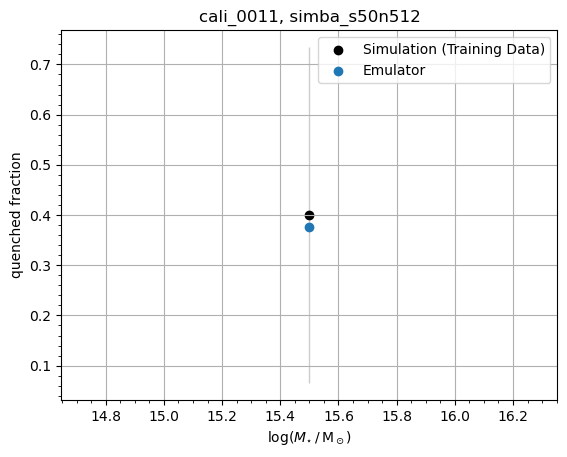

x:  [15.5]
y:  [0.17058634]
yerr:  [0.00172824]
Slope:  []


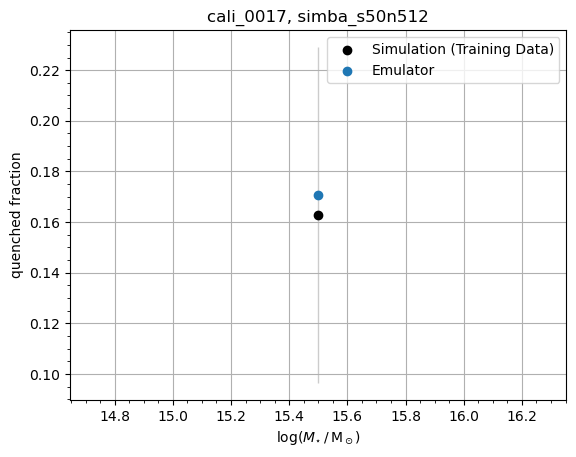

x:  [15.5]
y:  [0.11881361]
yerr:  [0.00047664]
Slope:  []


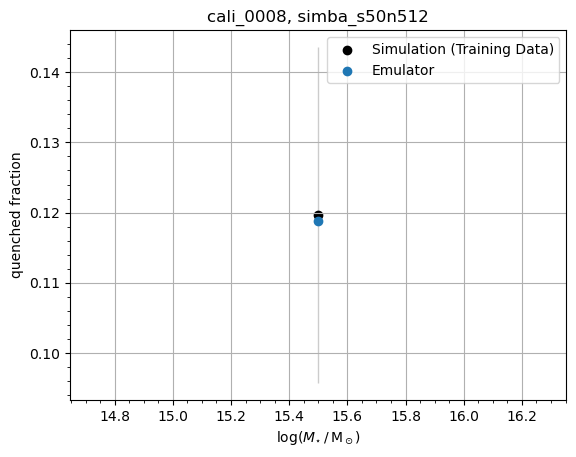

x:  [15.5]
y:  [9.11811884e-06]
yerr:  [1.2500001e-12]
Slope:  []


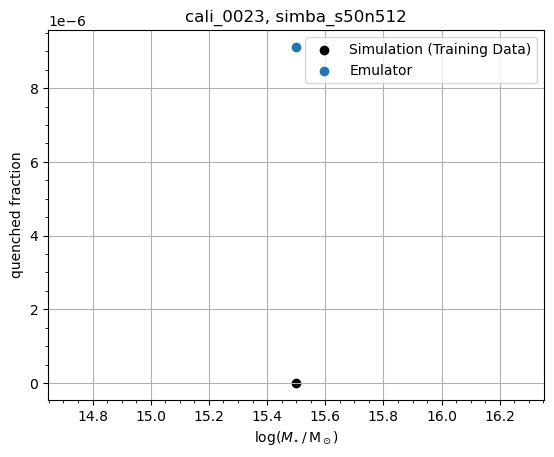

x:  [15.5]
y:  [0.49657531]
yerr:  [0.00280275]
Slope:  []


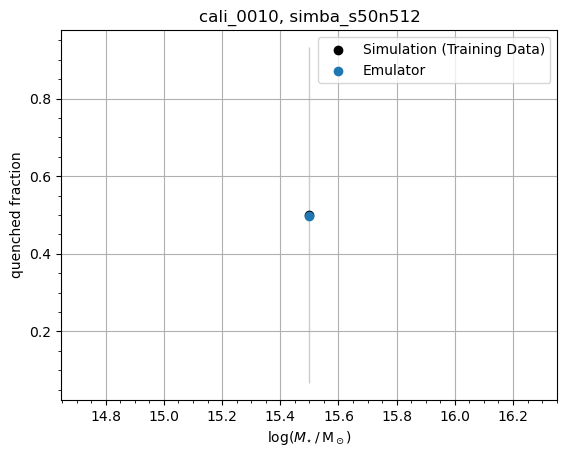

x:  [15.5]
y:  [0.20165929]
yerr:  [0.0024865]
Slope:  []


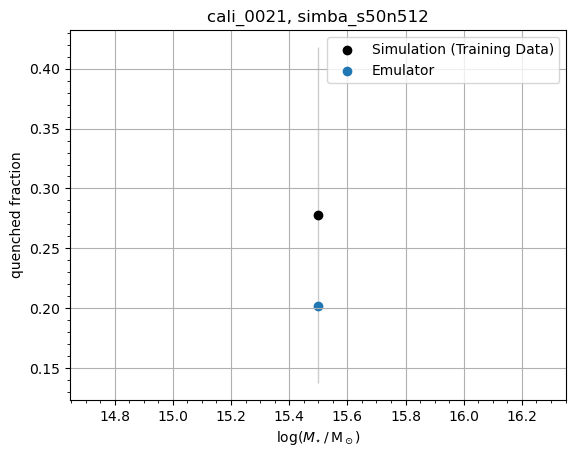

x:  [15.5]
y:  [0.31699391]
yerr:  [0.00264229]
Slope:  []


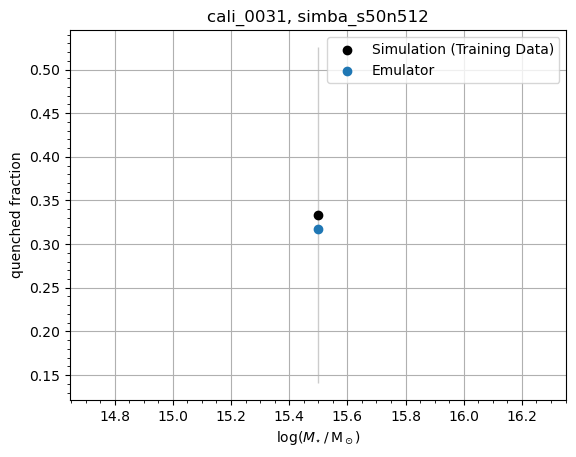

x:  [15.5]
y:  [0.35158021]
yerr:  [0.00214804]
Slope:  []


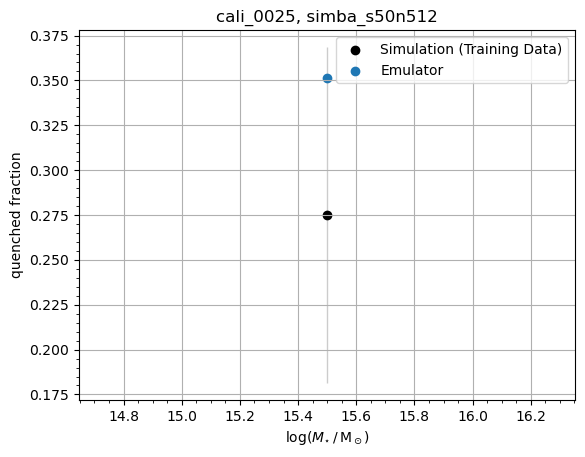

x:  [15.5]
y:  [0.3404829]
yerr:  [0.00229867]
Slope:  []


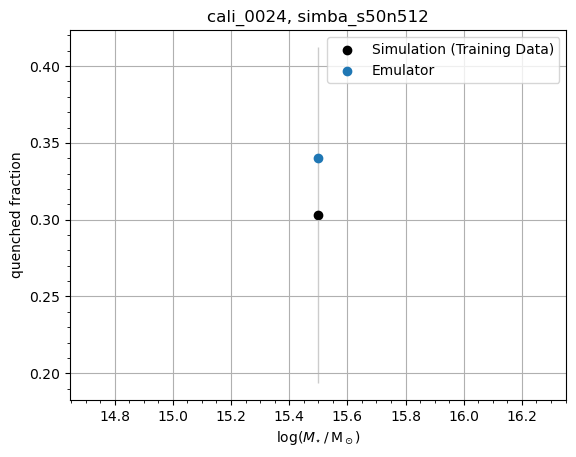

x:  [15.5]
y:  [0.33735066]
yerr:  [0.0024865]
Slope:  []


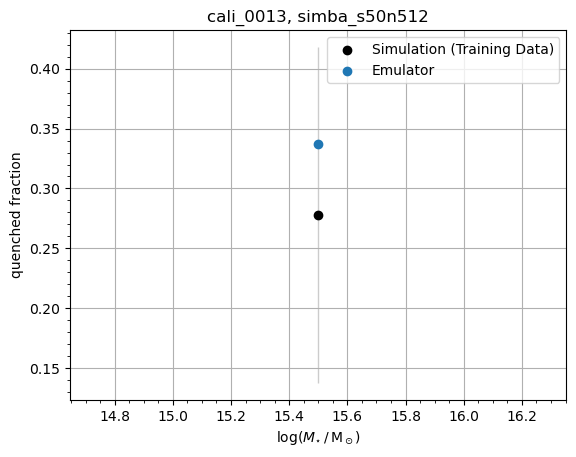

x:  [15.5]
y:  [0.20310635]
yerr:  [0.00264229]
Slope:  []


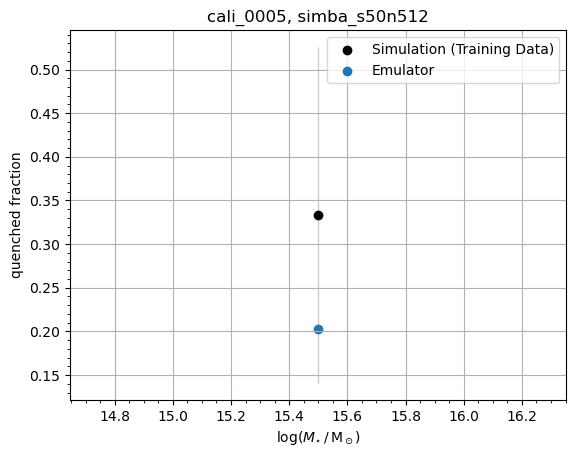

x:  [15.5]
y:  [0.46747504]
yerr:  [0.00280275]
Slope:  []


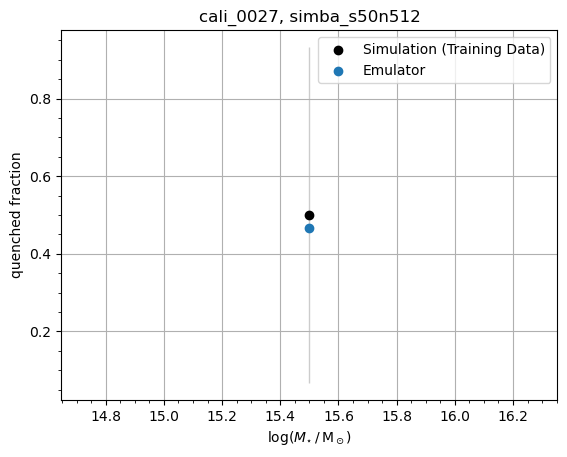

x:  [15.5]
y:  [0.39622147]
yerr:  [0.00258357]
Slope:  []


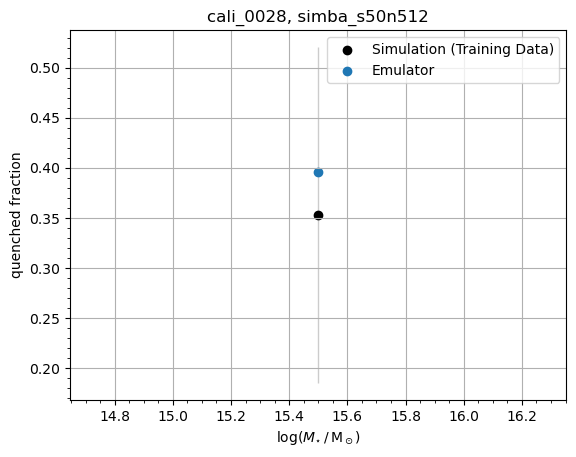

x:  [15.5]
y:  [0.3709917]
yerr:  [0.00251743]
Slope:  []


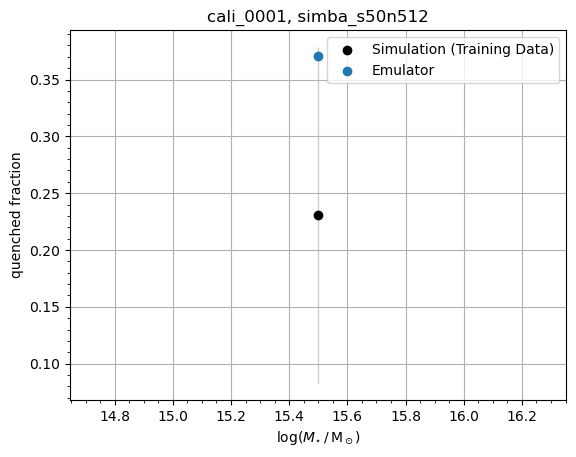

x:  [15.5]
y:  [0.43578881]
yerr:  [0.00282386]
Slope:  []


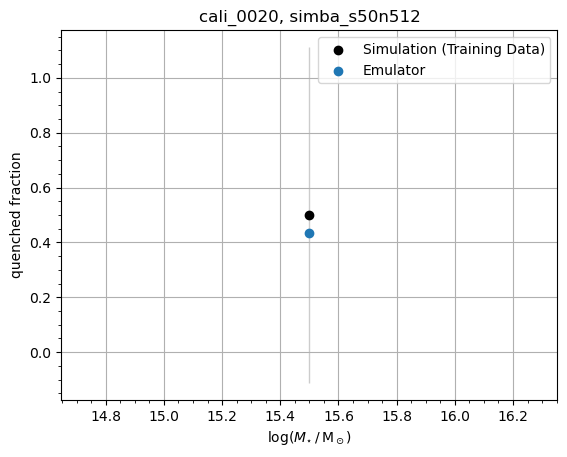

x:  [15.5]
y:  [0.25354375]
yerr:  [0.00251743]
Slope:  []


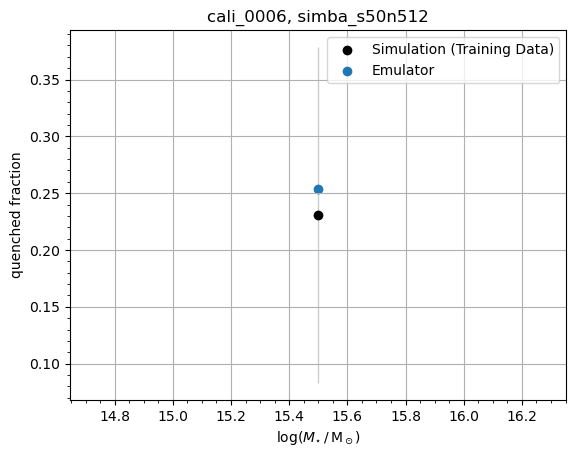

x:  [15.5]
y:  [0.09029081]
yerr:  [0.00098177]
Slope:  []


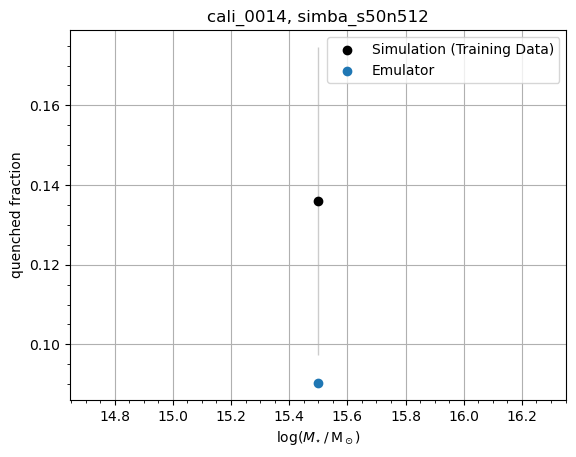

In [114]:
# Make predictions with trained emulator to compare to input

for cali in emulator.model_parameters.model_parameters:
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']
    sim_yerr = emulator.model_values[cali]['dependent_error']

    pred_y, pred_var = emulator.predict_values(pred_x, pred_params)
#     pred_y, pred_var = emulator.predict_values(pred_params)
    
    print("x: ", pred_x)
    print("y: ", pred_y)
    print("yerr: ", pred_var)
    print("Slope: ", [(y2-y1)/(x2-x1) for x1, x2, y1, y2 in zip(pred_x[:-1], pred_x[1:], pred_y[:-1], pred_y[1:])])

    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s' % (cali, snap_prefix))
    plt.grid()
    plt.minorticks_on()
    
#     plt.errorbar(pred_x, sim_y, yerr=sim_yerr, color="black", ls=":", label="Simulation (Training Data)")
    plt.plot(pred_x, sim_y, color="black", ls=":", label="Simulation (Training Data)")
#     plt.scatter(pred_x, sim_y, color="black", label="Simulation (Training Data)")
    plt.fill_between(pred_x, sim_y-sim_yerr, sim_y+sim_yerr, color="black", alpha=0.2)
    
    plt.errorbar(pred_x, pred_y, yerr=pred_var, ls='-', label='Emulator')
#     plt.scatter(pred_x, pred_y, label='Emulator')
    plt.legend()
    plt.show()

/tmp/ipykernel_207021/3879946254.py:15: RuntimeWarning: divide by zero encountered in divide
  pred_over_sim = pred_y/sim_y


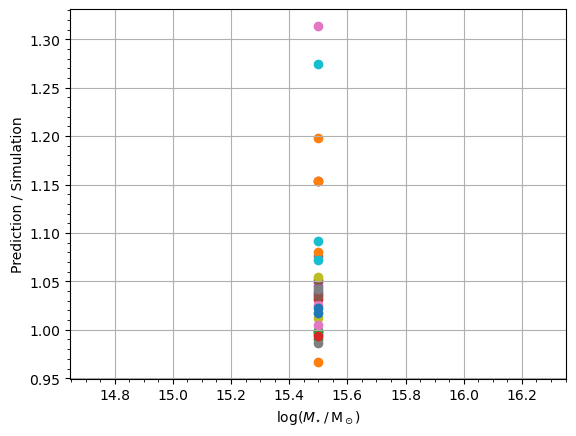

In [127]:
## See how far off each prediction is from its simulation

pred_over_sim_list = []
# pred_over_sim_list_v2 = []

for cali in emulator.model_parameters.model_parameters:
#     print(cali)
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']

    pred_y, pred_var = emulator.predict_values(pred_x, pred_params)
#     pred_y, pred_var = emulator.predict_values(pred_params)
    
    pred_over_sim = pred_y/sim_y
    pred_over_sim_list = np.append(pred_over_sim_list, pred_over_sim)
#     pred_over_sim_list_v2.append([pred_x, pred_over_sim])

    plt.plot(pred_x, pred_over_sim)
#     plt.scatter(pred_x, pred_over_sim)

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
plt.ylabel("Prediction / Simulation")
plt.show()

## Parameter sensitivity analysis

In [128]:
# If get division by zero error, it is because there is one (or multiple) emulator(s) that
# have x values that no others have --> need to either re-bin so emulators all have same x
# values, or remove that one point from that emulator
emulator_sensitivities = basic.binwise_sensitivity(specification=emulator.model_specification,
                                                   parameters=emulator.model_parameters,
                                                   values=emulator.model_values)
list(emulator_sensitivities.values())

[array([ 0.01805374, -0.4837025 ,  0.46835194,  0.01116107])]

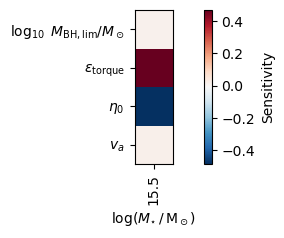

In [129]:
fig, ax = basic.plot_binwise_sensitivity(specification=emulator.model_specification,
                                         sensitivities=emulator_sensitivities,
                                         xlabel=sim_info['X_LABEL'],
                                         cbarlabel='Sensitivity',
                                         vmin=np.nanmin(list(emulator_sensitivities.values())),
                                         vmax=np.nanmax(list(emulator_sensitivities.values())))

# fig.set_size_inches(8, 8, forward=True)
fig.set_size_inches(8, 2, forward=True)

## Perform cross check (validation)

In [130]:
emulator_ccheck = cross_check.CrossCheck(hide_progress=False)
emulator_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

 97%|█████████▋| 31/32 [00:01<00:00, 26.87it/s]


ValueError: array must not contain infs or NaNs

In [75]:
data_by_cc = emulator_ccheck.build_mocked_model_values_original_independent()

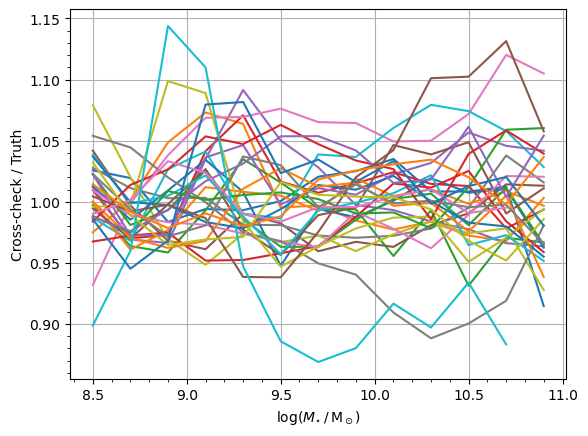

In [76]:
cc_list = []
cc_over_og_list = []
# cc_over_og_list_v2 = []

for unique_identifier in emulator_ccheck.model_values.model_values:
#     print(unique_identifier)
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / \
                model_values[unique_identifier]["dependent"]
#    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
#                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]

    cc_list = np.append(cc_list, data_by_cc[unique_identifier]["dependent"])
    cc_over_og_list = np.append(cc_over_og_list, cc_over_og)
#     cc_over_og_list_v2.append([data_by_cc[unique_identifier]["independent"], cc_over_og])
    
    plt.plot(data_by_cc[unique_identifier]["independent"], cc_over_og)

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
plt.ylabel("Cross-check / Truth")
plt.show()

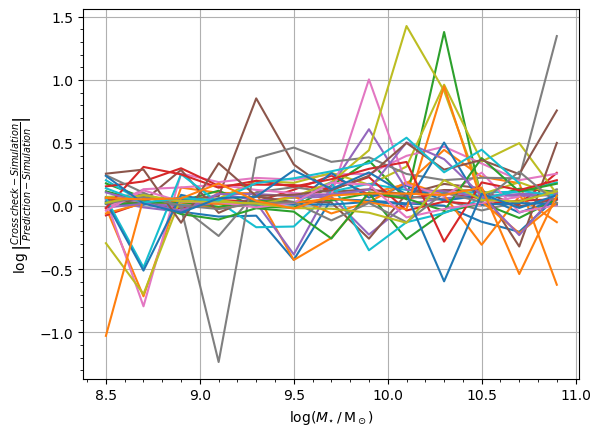

In [77]:
## Cross-check does better if y-axis value is negative
## Original prediction does better if y-axis value is positive

# cc_over_og_list = []
# cc_over_og_list_v2 = []
pred_list = []

for unique_identifier in emulator_ccheck.model_values.model_values:
    
    pred_params = emulator.model_parameters[unique_identifier]
    pred_x = emulator.model_values[unique_identifier]['independent']
    sim_y = emulator.model_values[unique_identifier]['dependent']

    pred_y, pred_var = emulator.predict_values(pred_x, pred_params)
    
    pred_list = np.append(pred_list, pred_y)
    
    
#     cc_over_pred = data_by_cc[unique_identifier]["dependent"] / pred_y
# #    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
# #                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]
# #     cc_over_og_list = np.append(cc_over_og_list, cc_over_og)
# #     cc_over_og_list_v2.append([data_by_cc[unique_identifier]["independent"], cc_over_og])
#     plt.plot(data_by_cc[unique_identifier]["independent"], cc_over_pred)
    
    
    val_ = np.log10(np.abs((data_by_cc[unique_identifier]["dependent"] - sim_y)/(pred_y - sim_y)))
    plt.plot(data_by_cc[unique_identifier]["independent"], val_)

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
# plt.ylabel("Cross-check / Prediction")
plt.ylabel(r'$\log{ \left| \frac{Cross \, check - Simulation}{Prediction - Simulation} \right|}$')
plt.show()

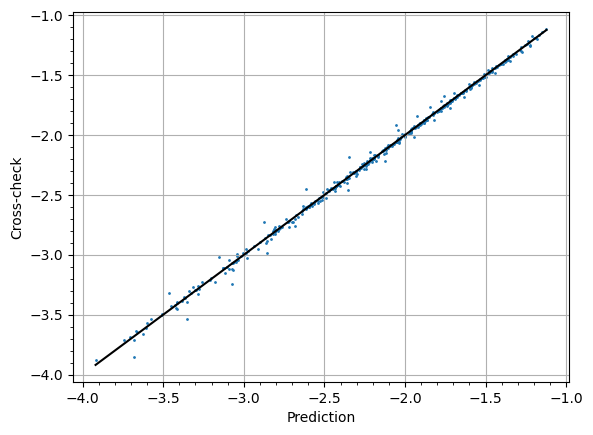

In [79]:
## Second way of comparing the cross-check for each simulation to the prediction as found by
## the fully trained emulator

plt.plot([min(pred_list), max(pred_list)], [min(pred_list), max(pred_list)], color='black')
plt.scatter(pred_list, cc_list, s=1)

plt.grid()
plt.minorticks_on()
plt.xlabel("Prediction")
plt.ylabel("Cross-check")
plt.show()

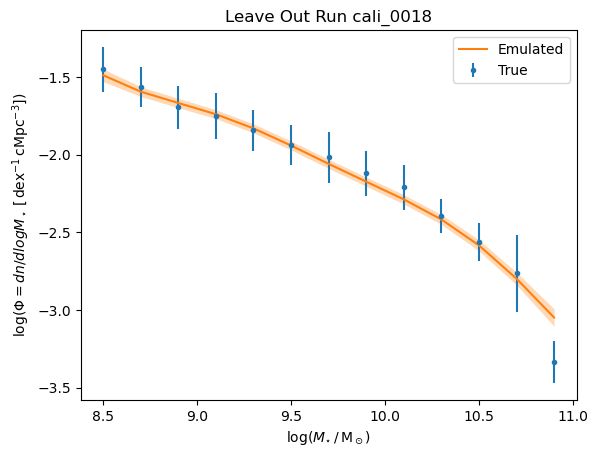

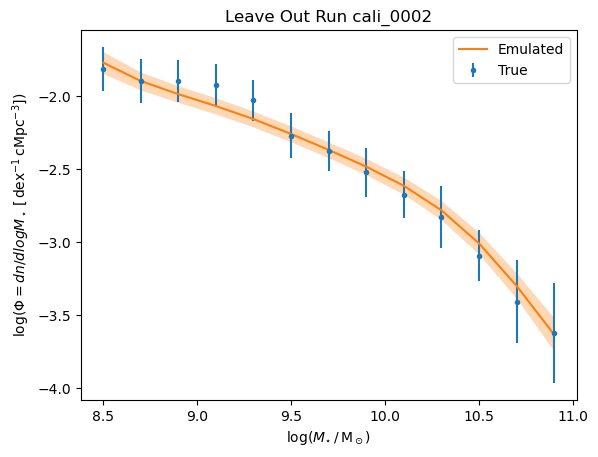

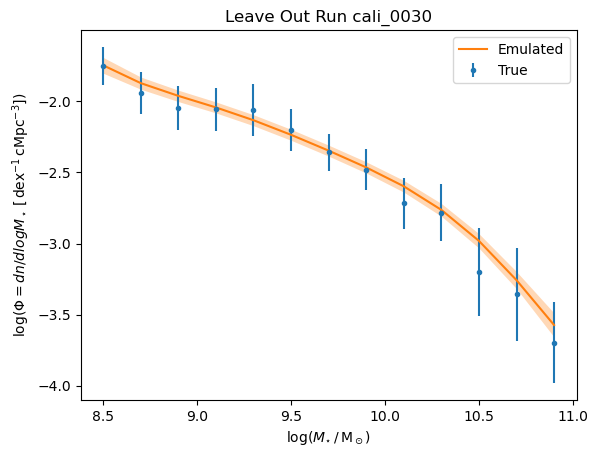

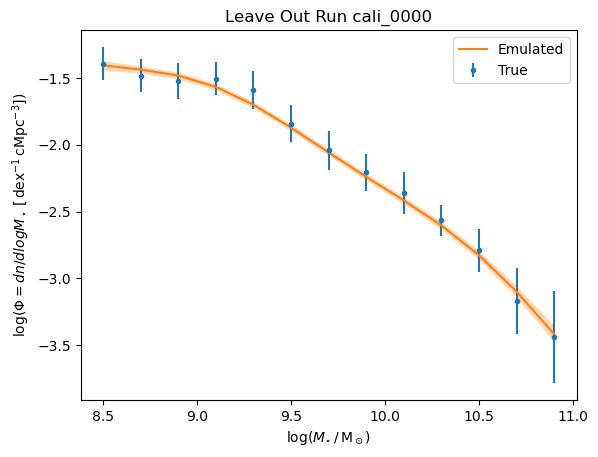

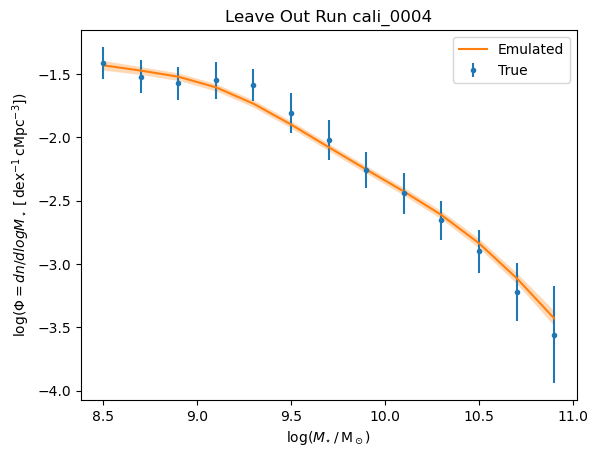

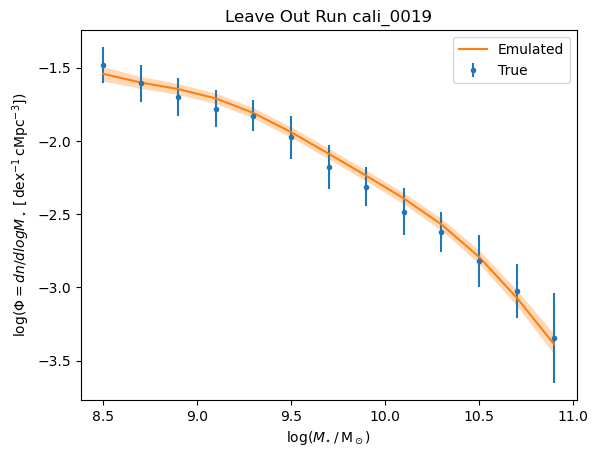

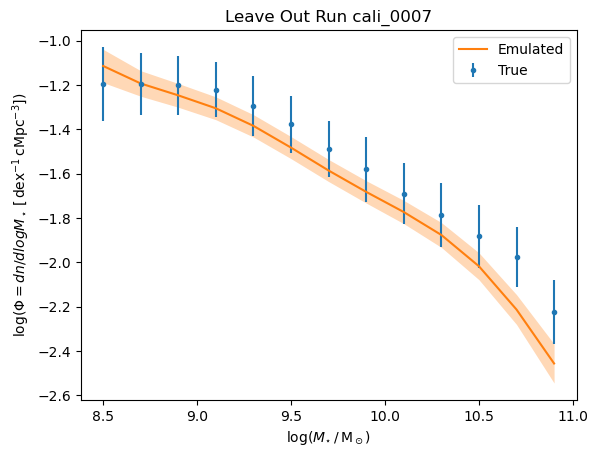

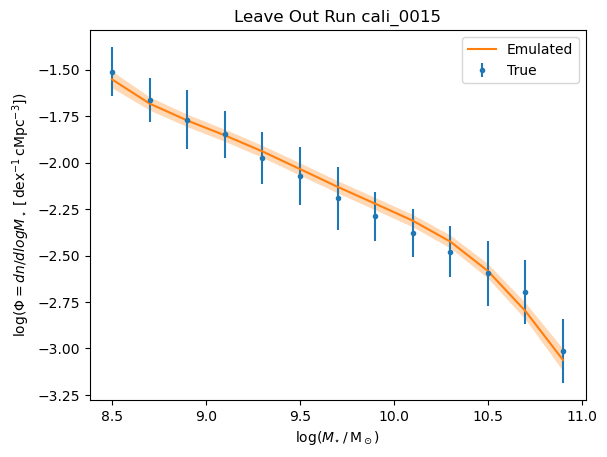

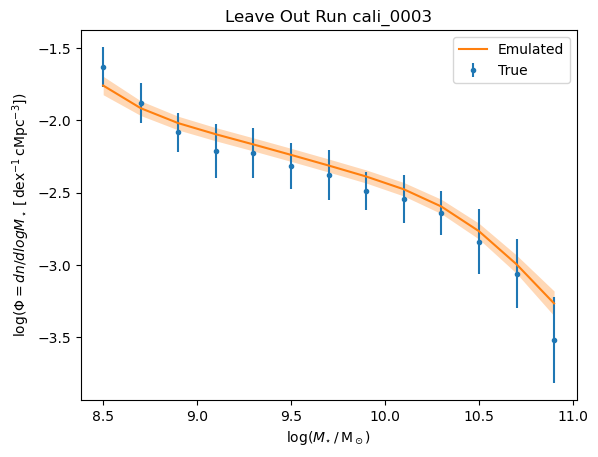

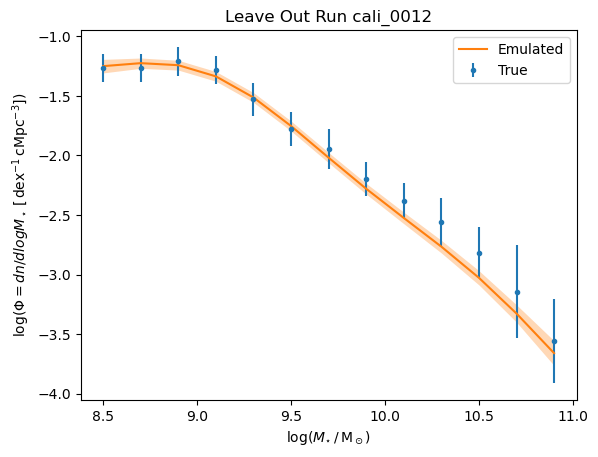

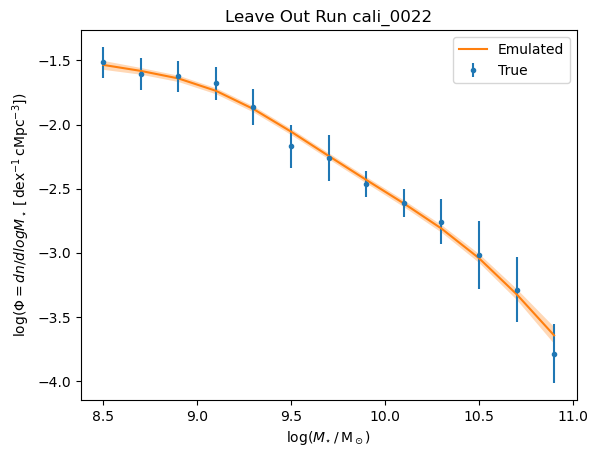

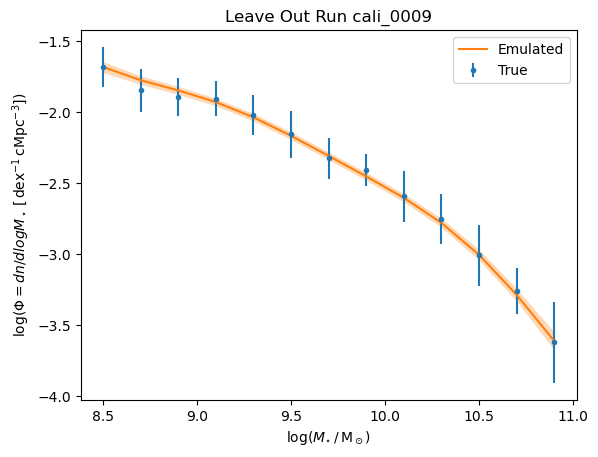

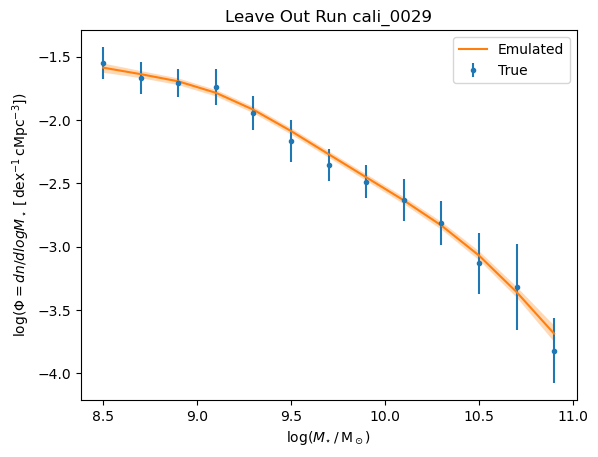

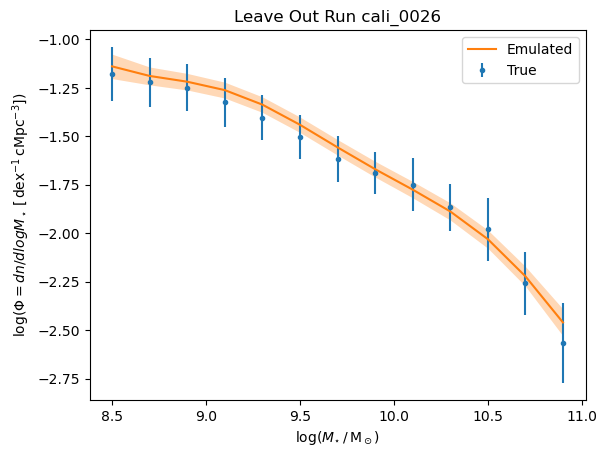

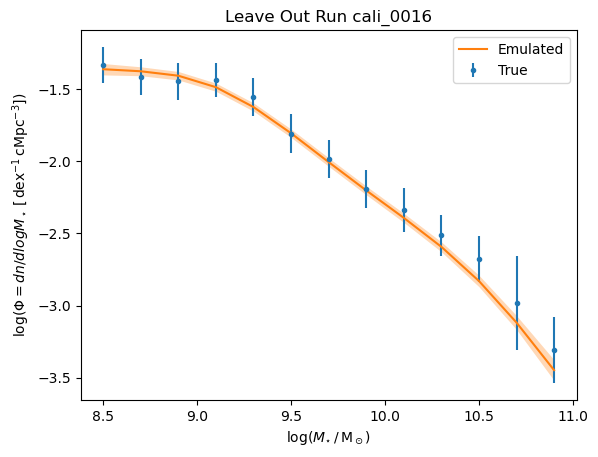

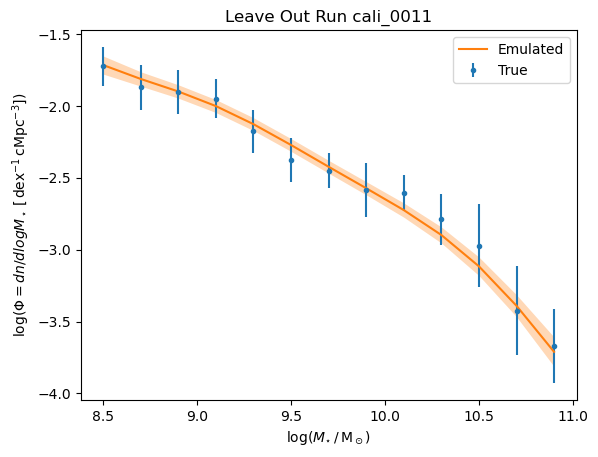

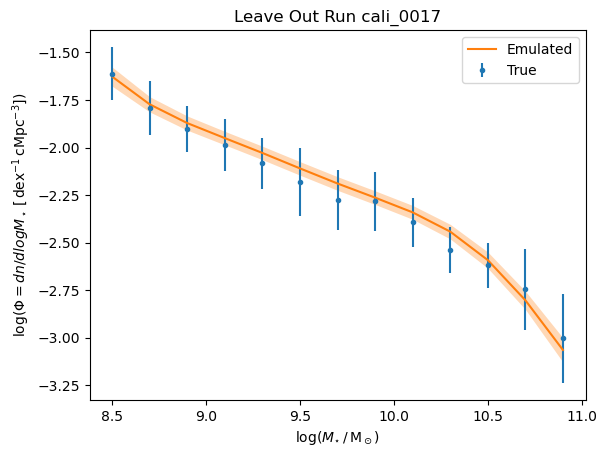

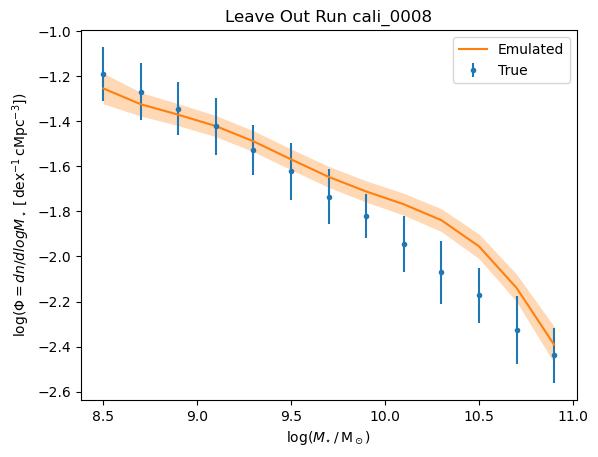

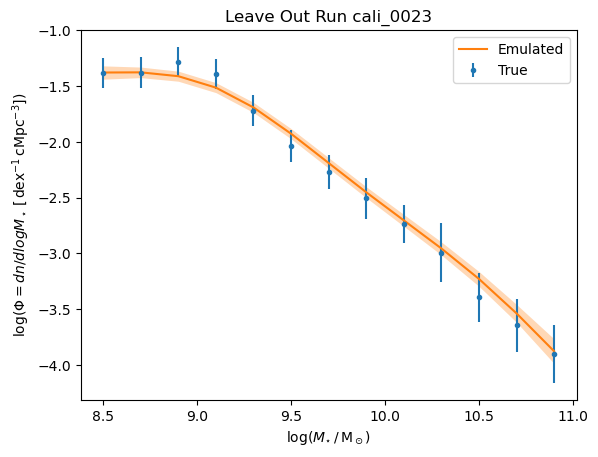

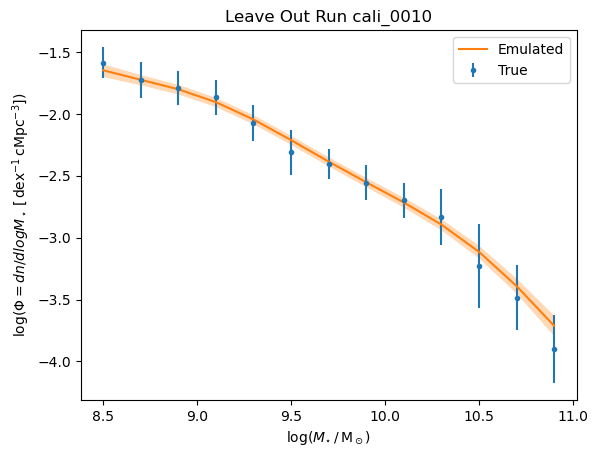

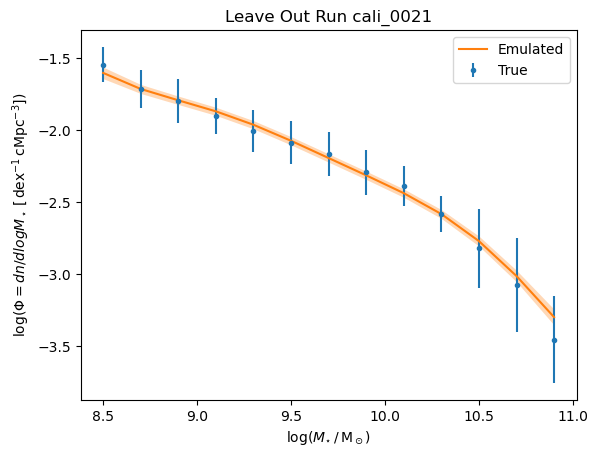

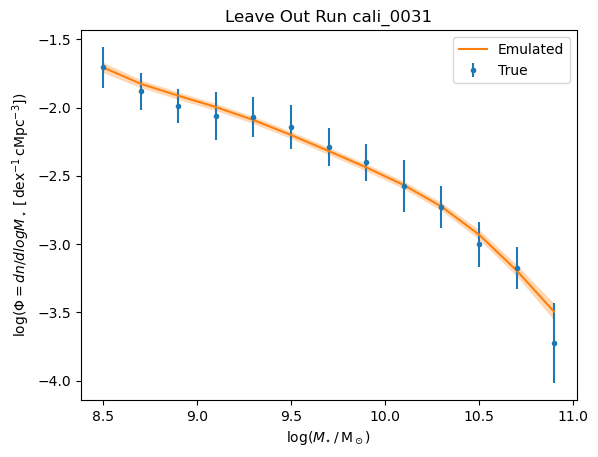

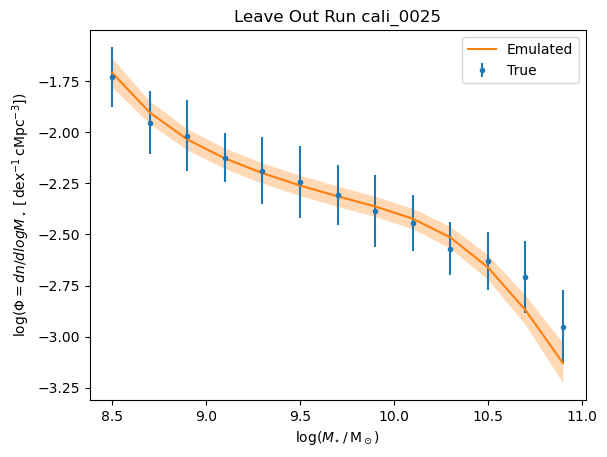

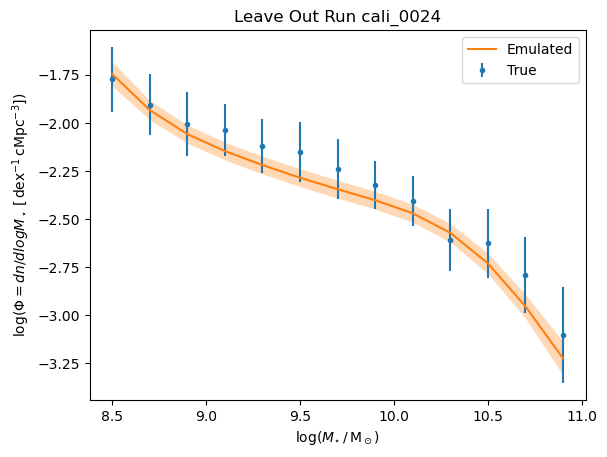

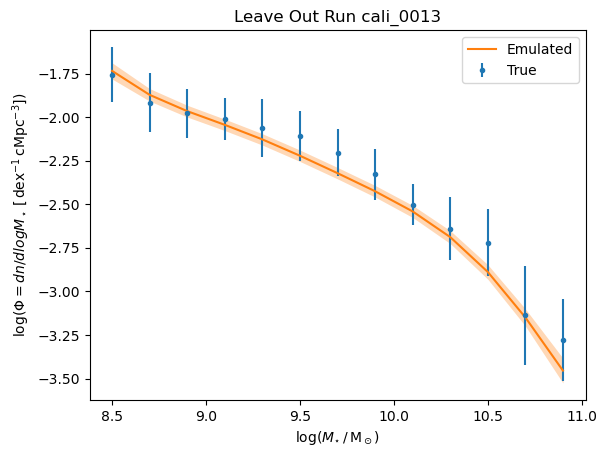

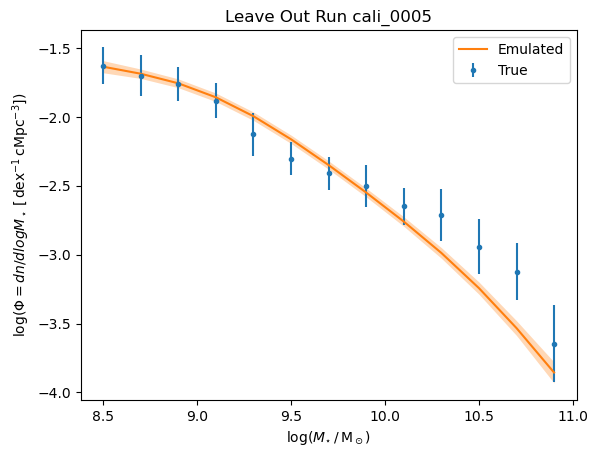

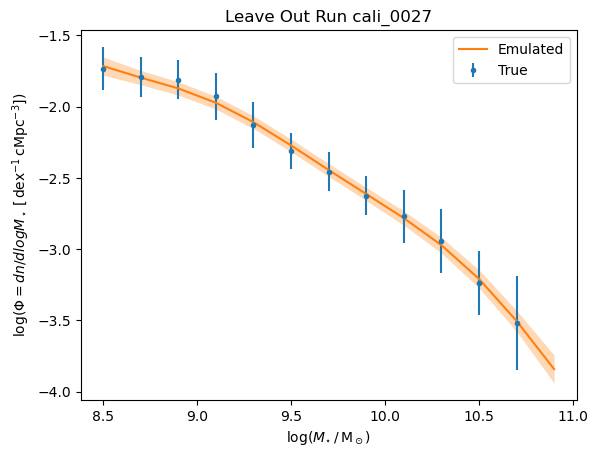

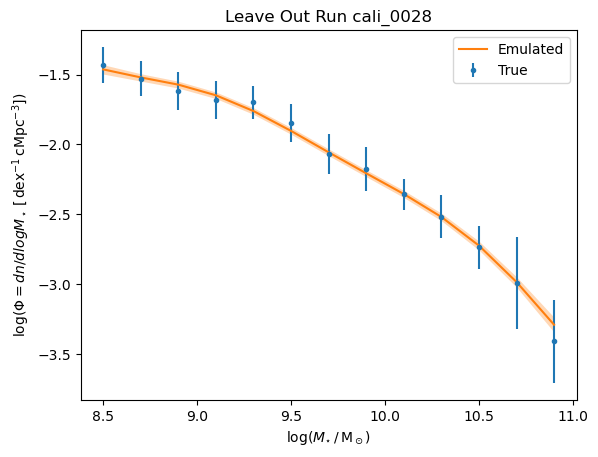

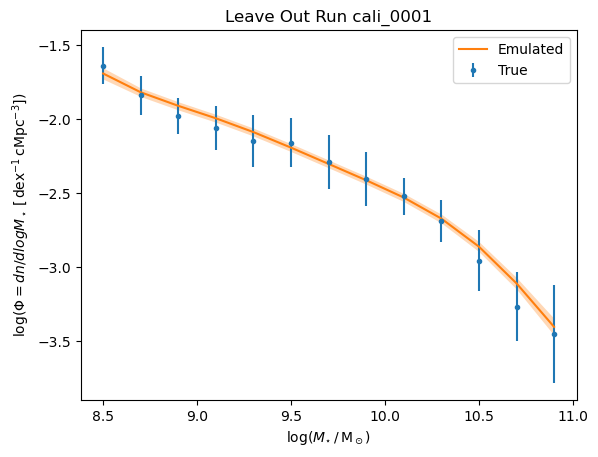

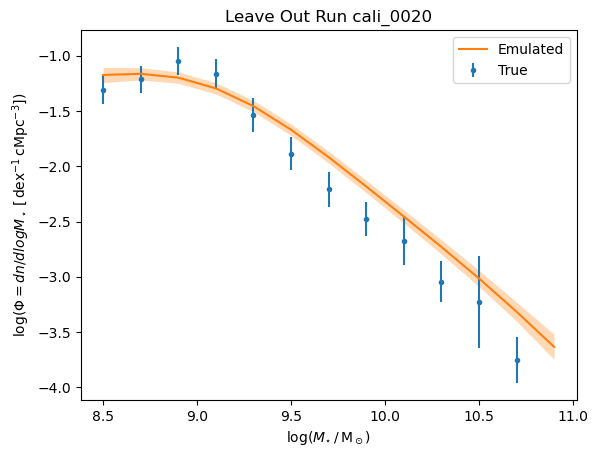

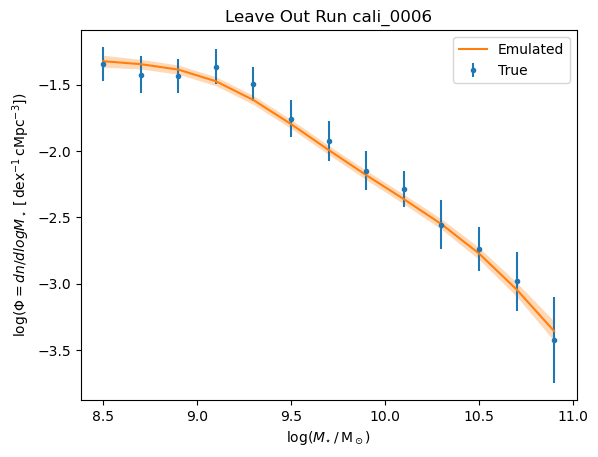

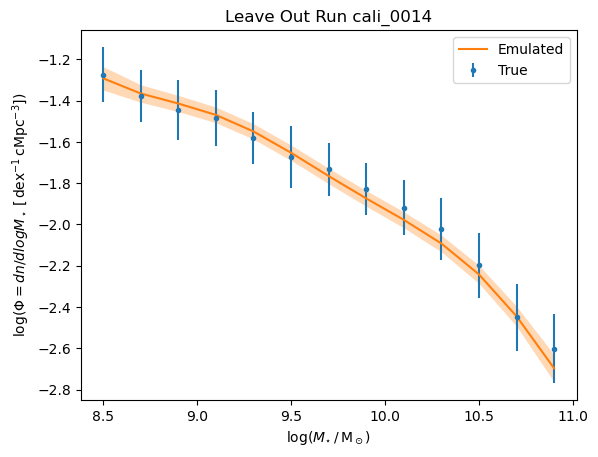

In [81]:
emulator_ccheck.plot_results(emulate_at=data_by_cc[unique_identifier]["independent"],
                         xlabel=sim_info['X_LABEL'],
                         ylabel=sim_info['Y_LABEL'])

In [82]:
total_mean_squared = emulator_ccheck.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

Total mean squared of entire set of left-out simulations: 0.008122685237884574


In [140]:
## As in FLAMINGO paper (Kugel+22), error on emulator approximated as standard deviation of
## cross-check values divided by original simulation values

# sigma_ccheck = np.nanstd(cc_over_og_list)#, ddof=0)
# sigma_ccheck = total_mean_squared
sigma_ccheck = 0.1
print('sigma_ccheck =', sigma_ccheck)
emulator.model_specification.sigma_ccheck = sigma_ccheck

sigma_ccheck = 0.1


In [141]:
def emulator_model(x, pred_params, emulator):
    pred_y, pred_var = emulator.predict_values(x, pred_params)
    
    pred_std = np.sqrt(pred_var)
    pred_ccheck_std = np.abs(emulator.model_specification.sigma_ccheck * pred_y)
    pred_total = np.sqrt(pred_std**2 + pred_ccheck_std**2)
    
    return pred_y, pred_ccheck_std

x:  [15.5]
pred_y:  [0.21342435]
pred_yerr:  [0.02134244]


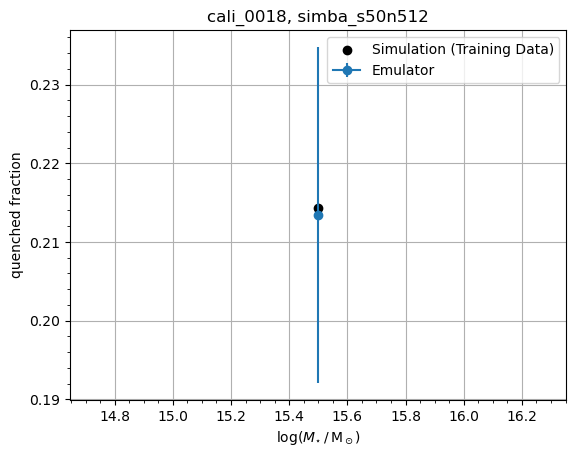

x:  [15.5]
pred_y:  [0.23960901]
pred_yerr:  [0.0239609]


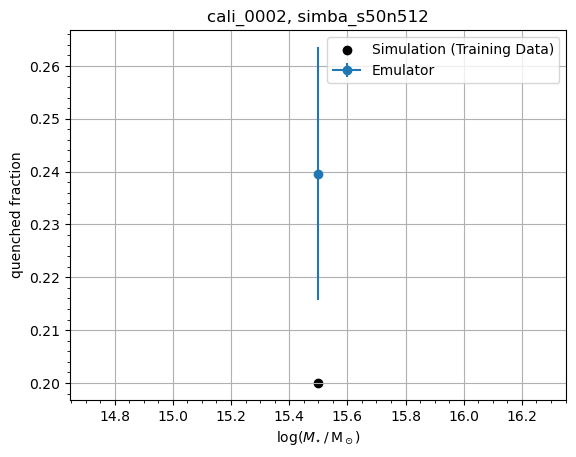

x:  [15.5]
pred_y:  [0.42796331]
pred_yerr:  [0.04279633]


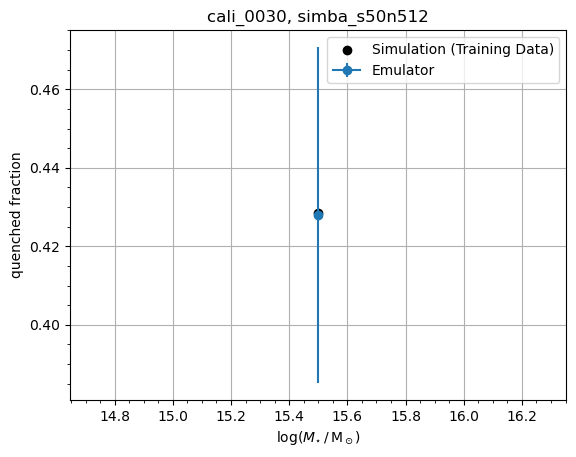

x:  [15.5]
pred_y:  [0.51585405]
pred_yerr:  [0.0515854]


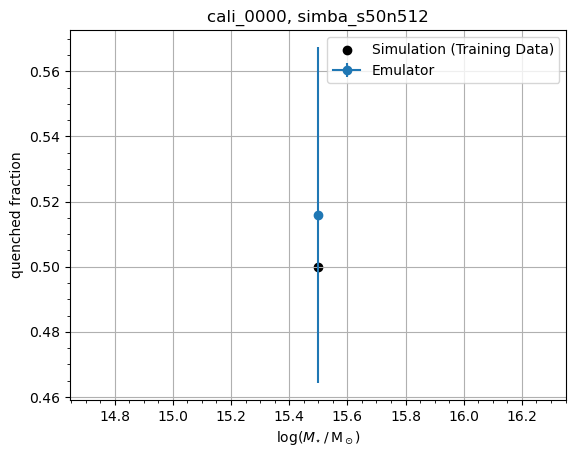

x:  [15.5]
pred_y:  [0.28544626]
pred_yerr:  [0.02854463]


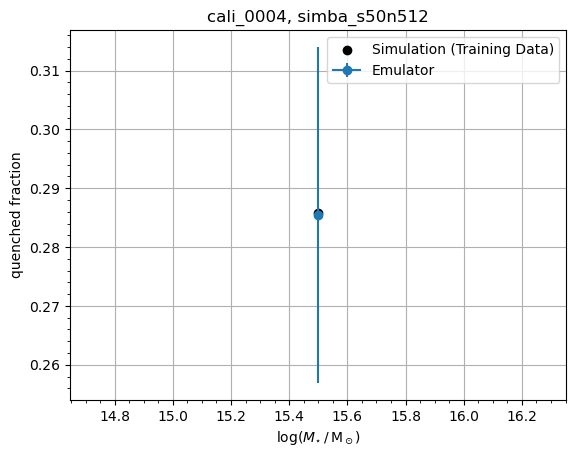

x:  [15.5]
pred_y:  [0.19670104]
pred_yerr:  [0.0196701]


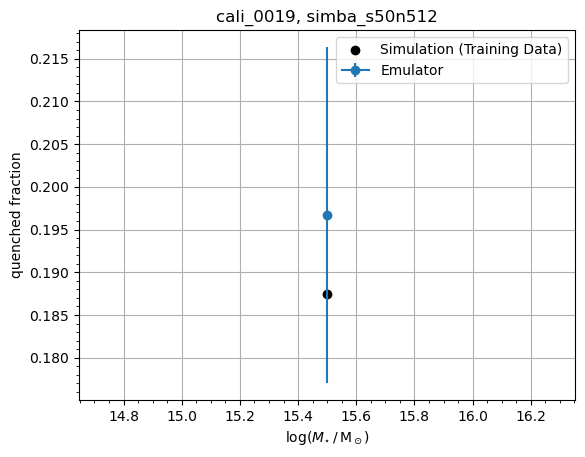

x:  [15.5]
pred_y:  [0.08201531]
pred_yerr:  [0.00820153]


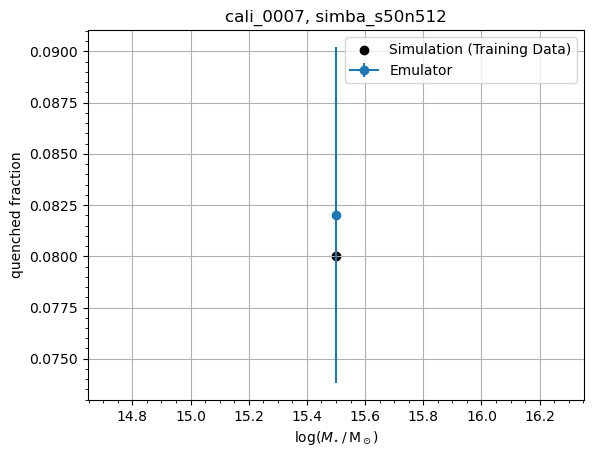

x:  [15.5]
pred_y:  [0.2390591]
pred_yerr:  [0.02390591]


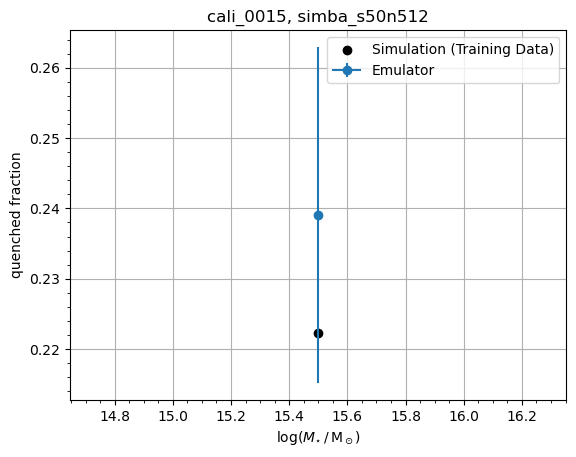

x:  [15.5]
pred_y:  [0.57853681]
pred_yerr:  [0.05785368]


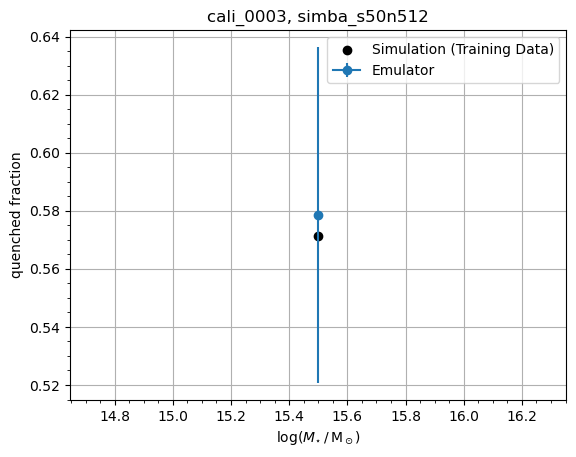

x:  [15.5]
pred_y:  [0.1158909]
pred_yerr:  [0.01158909]


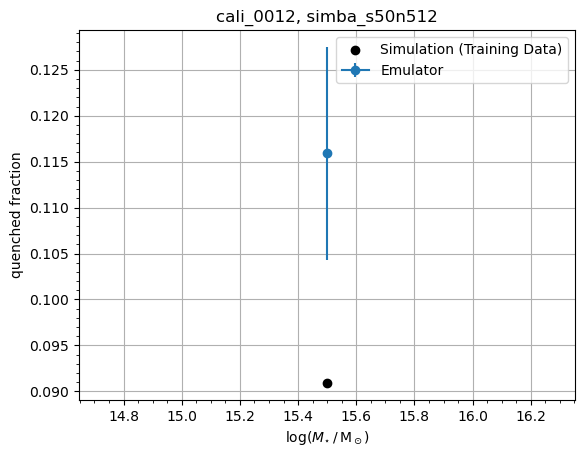

x:  [15.5]
pred_y:  [0.44523651]
pred_yerr:  [0.04452365]


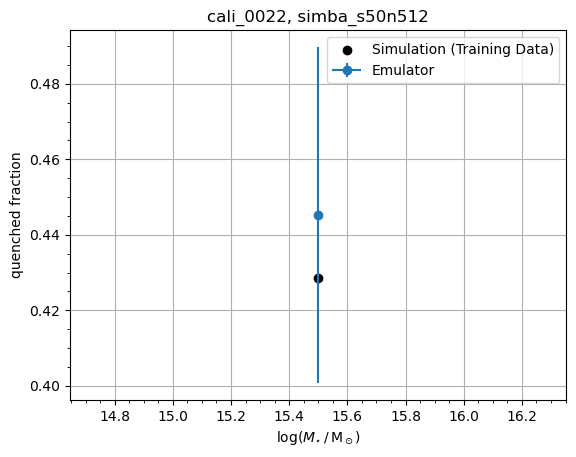

x:  [15.5]
pred_y:  [0.24168408]
pred_yerr:  [0.02416841]


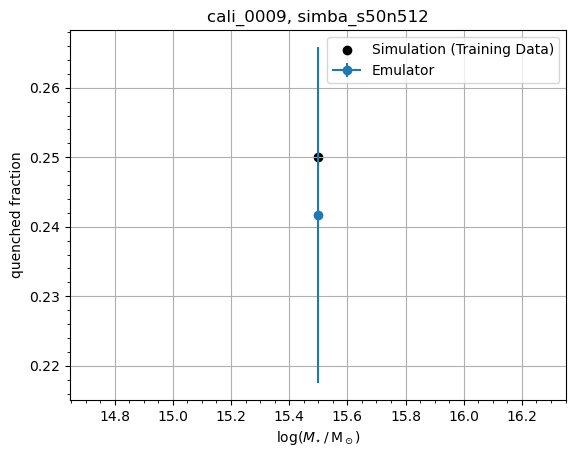

x:  [15.5]
pred_y:  [0.33018521]
pred_yerr:  [0.03301852]


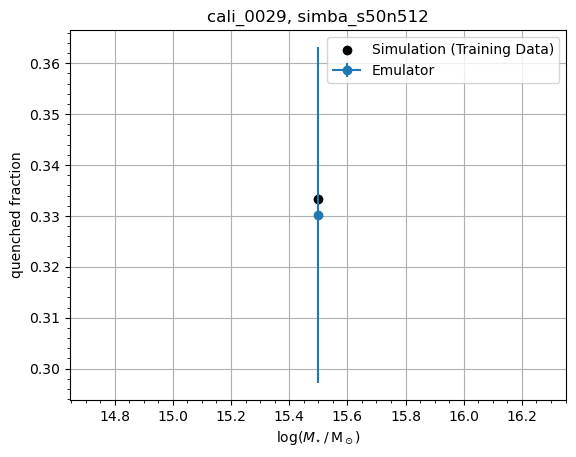

x:  [15.5]
pred_y:  [0.13188119]
pred_yerr:  [0.01318812]


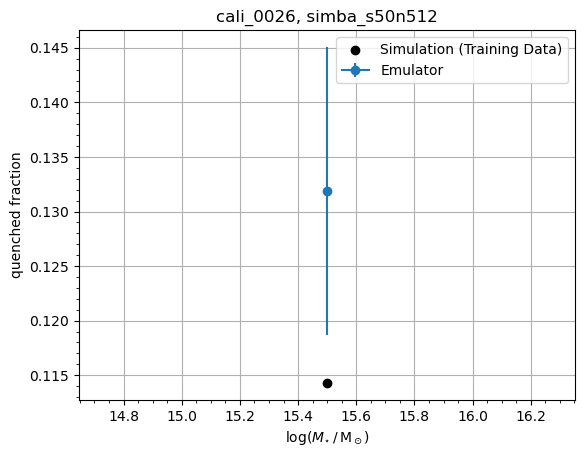

x:  [15.5]
pred_y:  [0.3190157]
pred_yerr:  [0.03190157]


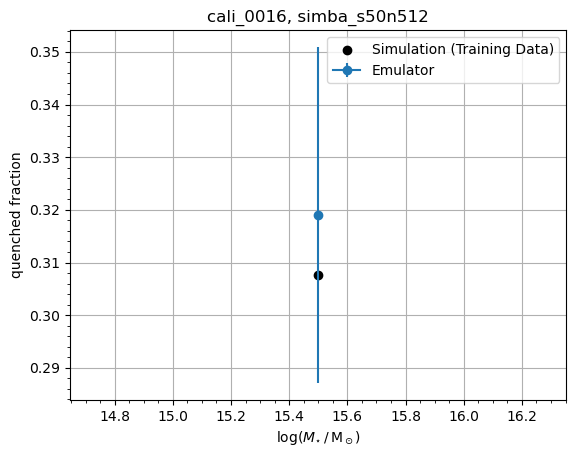

x:  [15.5]
pred_y:  [0.41398656]
pred_yerr:  [0.04139866]


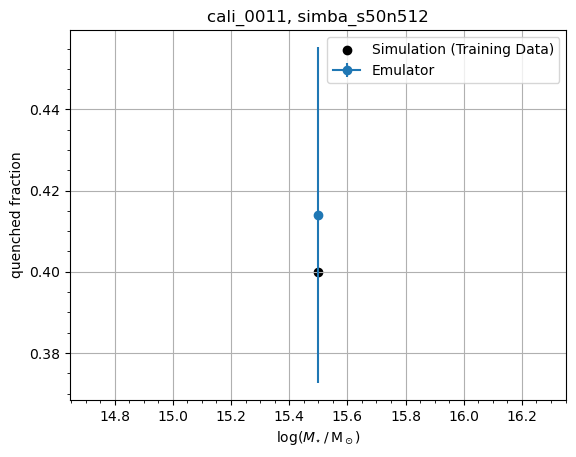

x:  [15.5]
pred_y:  [0.21385154]
pred_yerr:  [0.02138515]


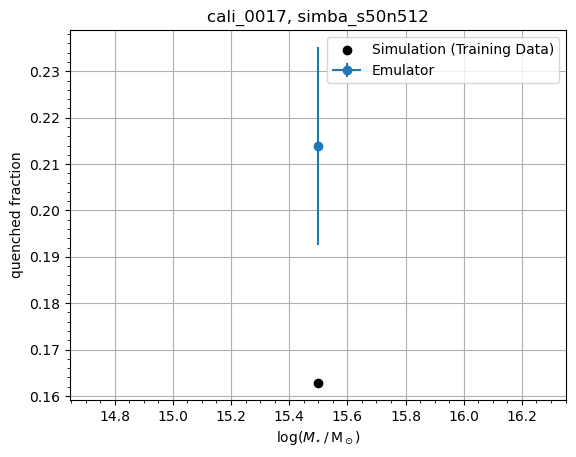

x:  [15.5]
pred_y:  [0.11808716]
pred_yerr:  [0.01180872]


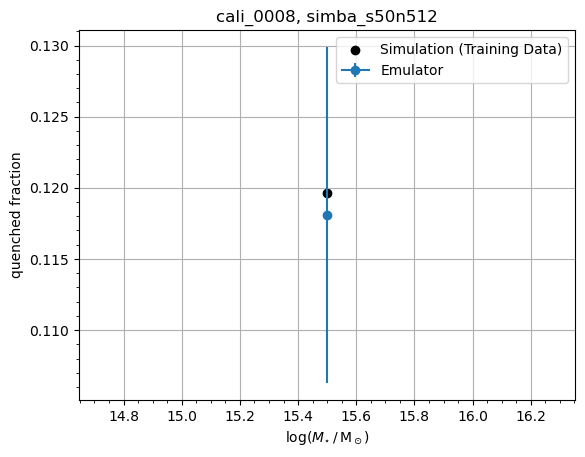

x:  [15.5]
pred_y:  [-1.48081072e-05]
pred_yerr:  [1.48081072e-06]


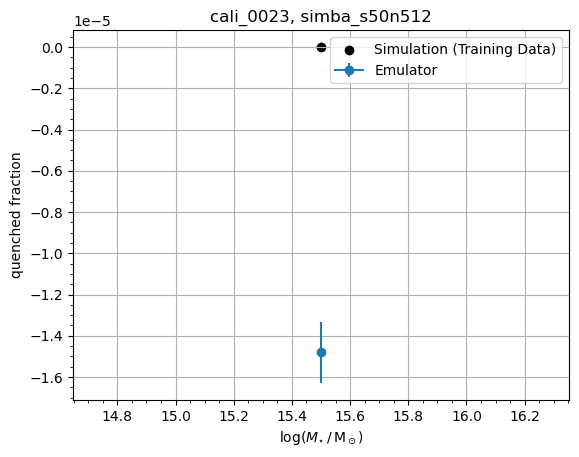

x:  [15.5]
pred_y:  [0.54600558]
pred_yerr:  [0.05460056]


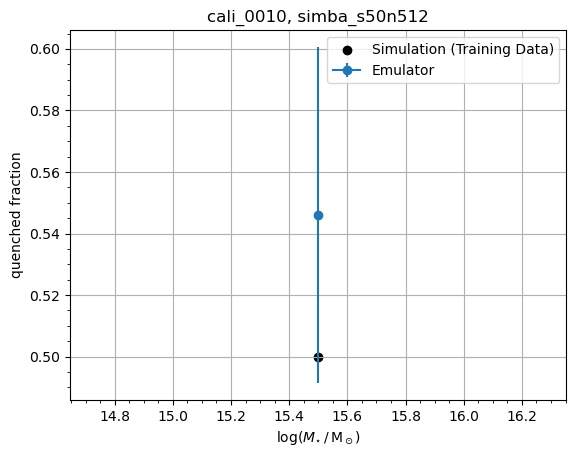

x:  [15.5]
pred_y:  [0.28251627]
pred_yerr:  [0.02825163]


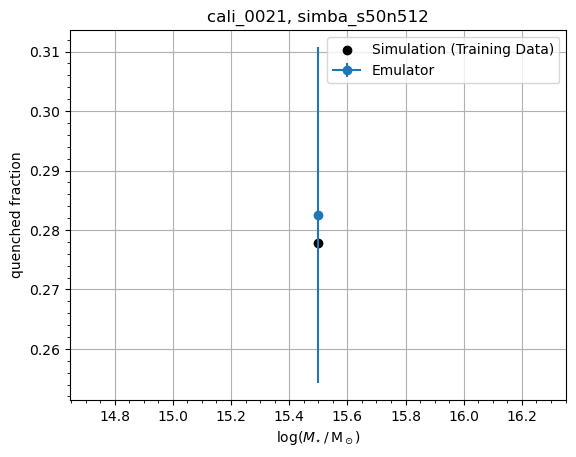

x:  [15.5]
pred_y:  [0.36003108]
pred_yerr:  [0.03600311]


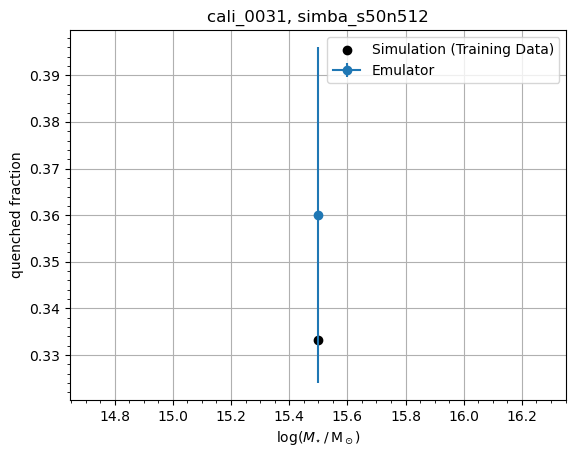

x:  [15.5]
pred_y:  [0.27470353]
pred_yerr:  [0.02747035]


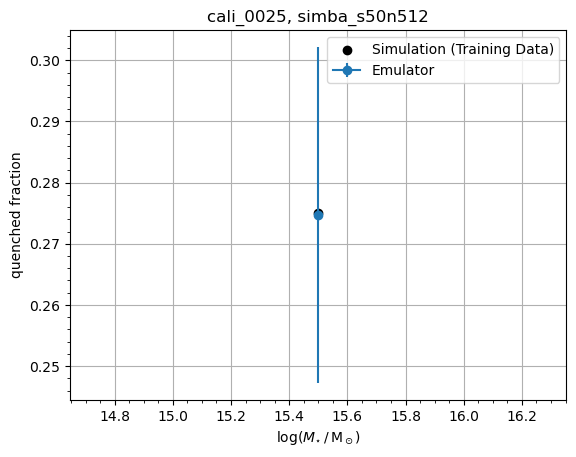

x:  [15.5]
pred_y:  [0.30107092]
pred_yerr:  [0.03010709]


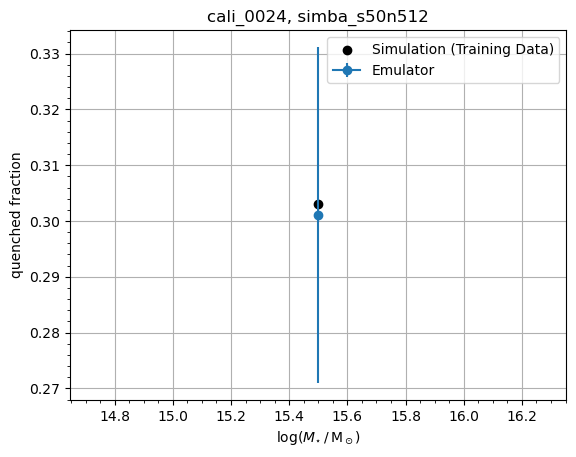

x:  [15.5]
pred_y:  [0.29026785]
pred_yerr:  [0.02902679]


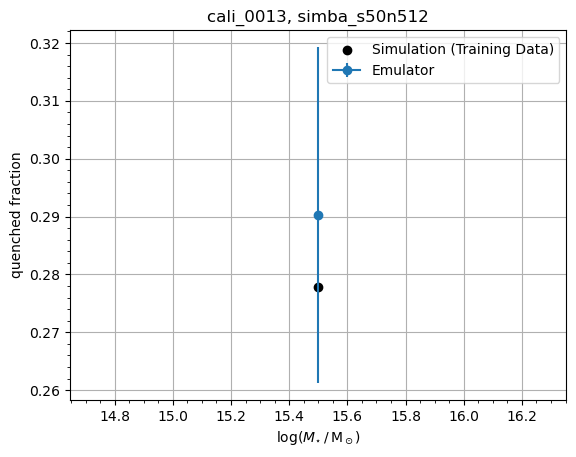

x:  [15.5]
pred_y:  [0.35038796]
pred_yerr:  [0.0350388]


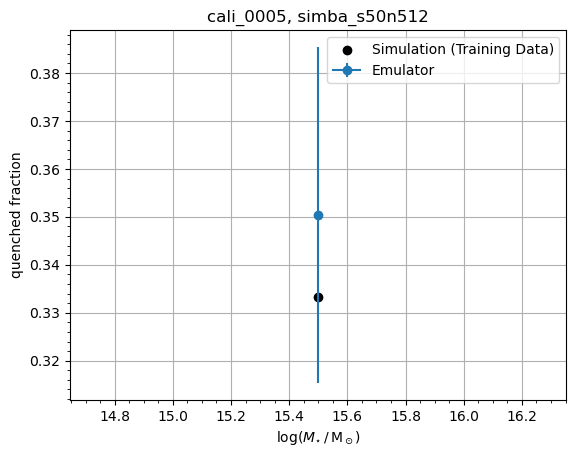

x:  [15.5]
pred_y:  [0.5024876]
pred_yerr:  [0.05024876]


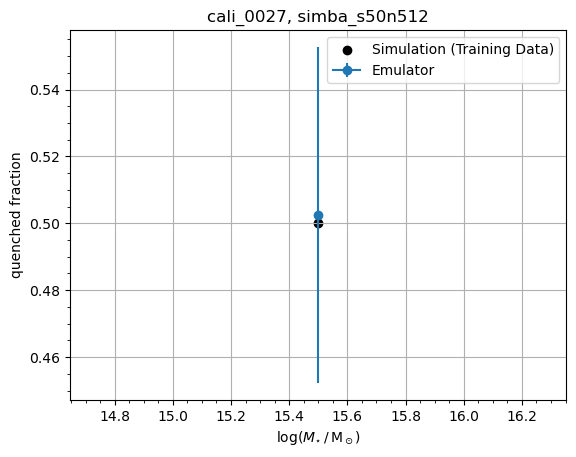

x:  [15.5]
pred_y:  [0.3679657]
pred_yerr:  [0.03679657]


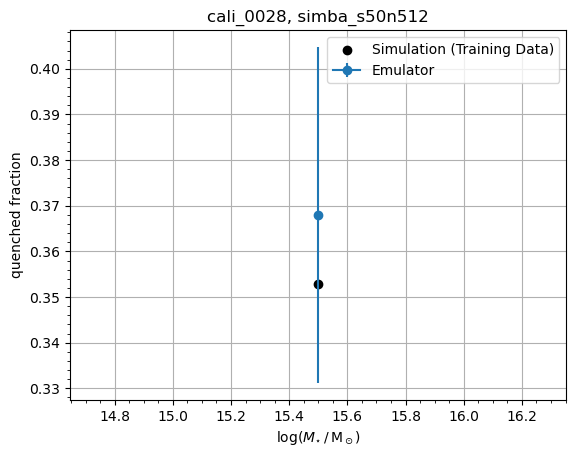

x:  [15.5]
pred_y:  [0.24327075]
pred_yerr:  [0.02432708]


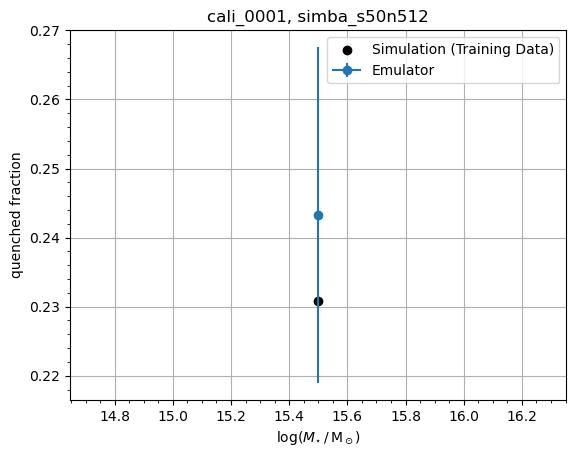

x:  [15.5]
pred_y:  [0.53624009]
pred_yerr:  [0.05362401]


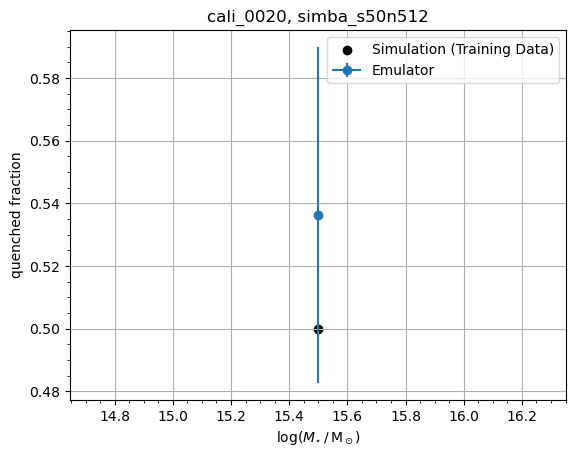

x:  [15.5]
pred_y:  [0.2358858]
pred_yerr:  [0.02358858]


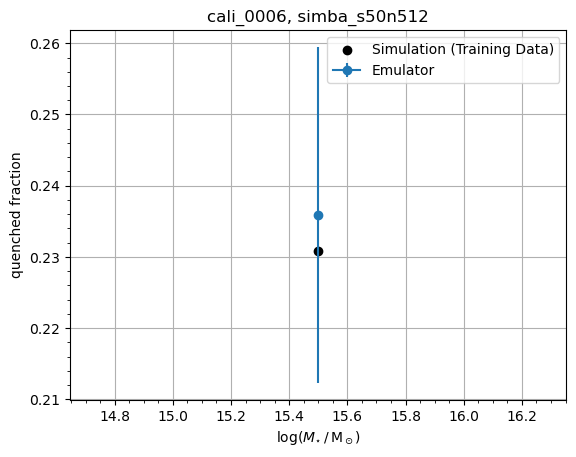

x:  [15.5]
pred_y:  [0.15678352]
pred_yerr:  [0.01567835]


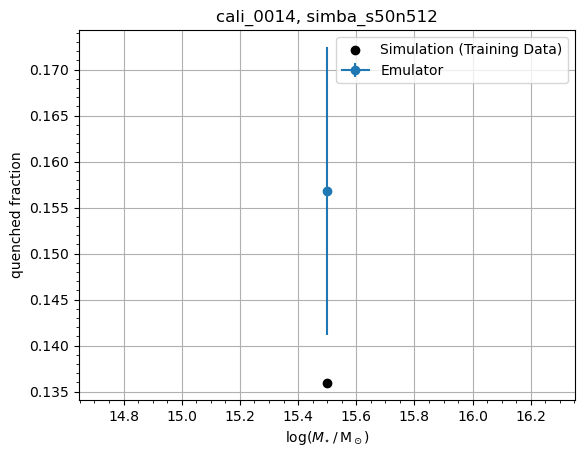

In [143]:
# Make predictions with trained emulator (but now with emulator uncertainties!) to compare to input

for cali in emulator.model_parameters.model_parameters:
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']
    sim_yerr = emulator.model_values[cali]['dependent_error']
    
    pred_y, pred_err = emulator_model(pred_x, pred_params, emulator)

    print("x: ", pred_x)
    print("pred_y: ", pred_y)
    print("pred_yerr: ", pred_err) 

    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s' % (cali, snap_prefix))
    plt.grid()
    plt.minorticks_on()
    
#     plt.errorbar(pred_x, sim_y, yerr=sim_yerr, color="black", ls=":", label="Simulation (Training Data)")
    plt.errorbar(pred_x, sim_y, color="black", ls=":", label="Simulation (Training Data)")
#     plt.scatter(pred_x, sim_y, color="black", label="Simulation (Training Data)")
    plt.fill_between(pred_x, sim_y-sim_yerr, sim_y+sim_yerr, color='black', alpha=0.2)

#     plt.errorbar(pred_x, pred_y, yerr=pred_err, ls='-', fmt='o', label='Emulator')
    plt.errorbar(pred_x, pred_y, yerr=None, ls='-', label='Emulator')
#     plt.scatter(pred_x, pred_y, label='Emulator')
    plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.3)
    plt.legend()
    plt.show()

## Sweeps of parameter space

In [144]:
# Get full range of x values that have been used in training emulator

sim_x = []
for cali in emulator.model_values.model_values:
    sim_x_curr = emulator.model_values[cali]['independent']
    for x_val in sim_x_curr:
        if x_val not in sim_x:
            sim_x.append(x_val)
            
sim_x = np.array(np.sort(sim_x))
print(sim_x)

[15.5]


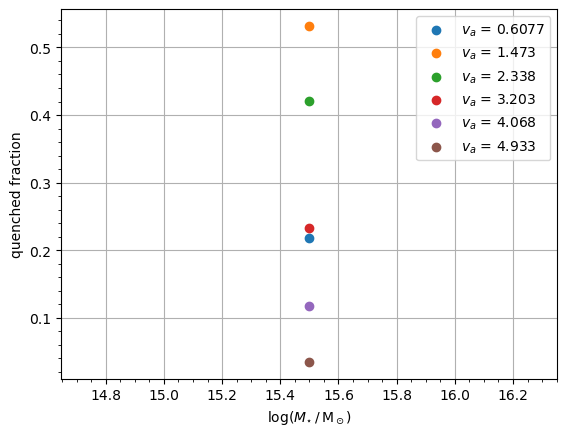

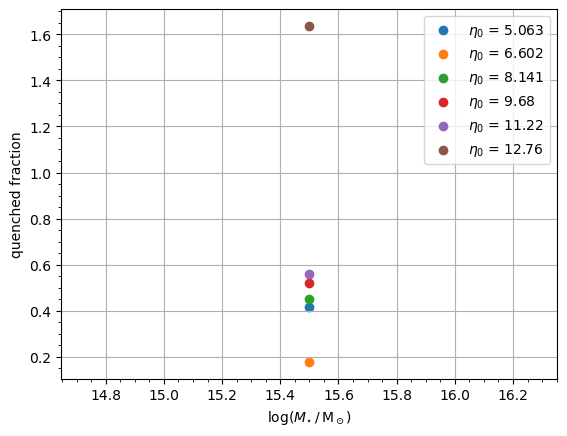

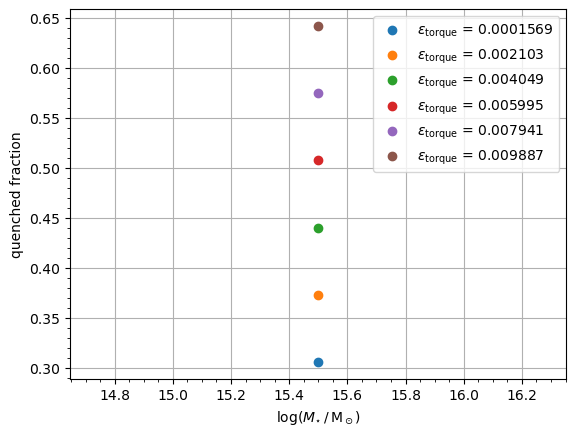

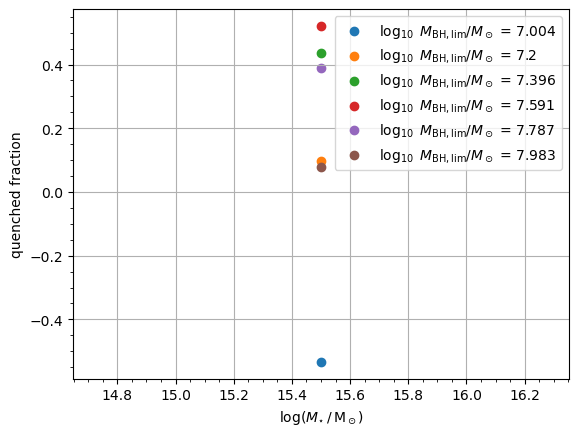

In [145]:
# Arbitrarily choose initial parameters to sweep from
# Doesn't matter too much though, because it ends up covering
# roughly the entire range of parameters used

centre = emulator.model_parameters['cali_0000']

# param_printable_names = []
for ii in range(len(emulator.parameter_order)):
    param_name = emulator.parameter_order[ii]
    param_printable_name = emulator.model_specification.parameter_printable_names[ii]
#     param_printable_names.append(param_printable_name)
    
    Mock_values, Mock_parameters = mock_sweep(emulator, emulator.model_specification, 6, param_name, centre)

    plt.clf()
    
    for mock_name in Mock_values.keys():
        plt.plot(Mock_values[mock_name]["independent"],
                Mock_values[mock_name]["dependent"],
                label = "%s = %.4g" % (param_printable_name, Mock_parameters[mock_name][param_name]))
#         plt.scatter(Mock_values[mock_name]["independent"],
#                 Mock_values[mock_name]["dependent"],
#                 label = "%s = %.4g" % (param_printable_name, Mock_parameters[mock_name][param_name]))
    
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Checking hyperparameters (doesn't always work)

In [762]:
emulator.kernel.get_parameter_dict(include_frozen=True)

OrderedDict([('k1:log_constant', -1.3862943611198906),
             ('k2:metric:log_M_0_0', 0.0),
             ('k2:metric:log_M_1_1', 0.0),
             ('k2:metric:log_M_2_2', 0.0),
             ('k2:metric:log_M_3_3', 0.0)])

In [763]:
emulator_mcmc = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(burn_in_steps=1, mcmc_steps=1000)#, hide_progress=False)
emulator_mcmc.fit_model(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

emcee: Exception while calling your likelihood function:
  params: [  -2.16770137   -2.03983901    2.76015305   -8.16779633 -785.74031846]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/gpfs/fs1/home/b/babul/aspadawe/src/emulator/swiftemulator/emulators/gaussian_process_mcmc.py", line 249, in log_likelihood
    return -negative_log_likelihood(p)
  File "/gpfs/fs1/home/b/babul/aspadawe/src/emulator/swiftemulator/emulators/gaussian_process_mcmc.py", line 242, in negative_log_likelihood
    return -gaussian_process.log_likelihood(self.dependent_variables)
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/george/gp.py", line 385, in log_likelihood
    if not self.recompute(quiet=quiet):
  File "/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/george/gp.py", line 355, in recompute
    self.compute(self._x, np.sqrt(self._yerr2), **kwargs)
  File "/home/b/babul/aspadawe/miniconda3

ValueError: array must not contain infs or NaNs

In [ ]:
emulator_mcmc.kernel.get_parameter_dict(include_frozen=True)

In [ ]:
emulator_mcmc.plot_hyperparameter_distribution()

## Save emulator to pickle file with dill module

In [45]:
def save_object(obj, filename):
    with open(filename, 'wb') as f:  # Overwrites any existing file.
        dill.dump(obj, f, dill.HIGHEST_PROTOCOL)

In [146]:
emulator_filename = 'emulator_'+obs_name+'_polynomial_degree_4.pkl'
emulator_path = os.path.join(root_dir, 'emulators')
if not os.path.isdir(emulator_path):
    os.makedirs(emulator_path, mode = 0o755, exist_ok=True)
save_object(emulator, os.path.join(emulator_path, emulator_filename))